# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
#instalo librerias
!pip install NLP
!pip install deplacy
!python -m spacy download es_core_news_sm
!pip install xgboost

     |████████████████████████████████| 1.7 MB 3.2 MB/s 
     |████████████████████████████████| 212 kB 62.1 MB/s 
     |████████████████████████████████| 16.2 MB 1.5 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=c2dc6a50779bff5b206358cb3deface0c60dfefbd3d6e58d46212cc640ddacd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-n9aumo7f/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [2]:
#EDA y preprocesamiento
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

## Libreria de performance:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', color_codes=True)
plt.style.use('fivethirtyeight')
#sns.set()

import nltk
nltk.download('spanish_grammars') #necesario para NLP en español.
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = stopwords.words('spanish') # idem stopwords.
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
import string
import re #regular Expresions (reemplazo de caracteres)

from nltk.stem import WordNetLemmatizer ## No tiene spanish      
from nltk.stem import SnowballStemmer   
import pkg_resources,imp
imp.reload(pkg_resources)
import spacy # tiene español
# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#ML:
#modelos:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

#evaluacion de modelos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

#optimización de modelos
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from scipy.stats import reciprocal, uniform

[nltk_data] Downloading package spanish_grammars to /root/nltk_data...
[nltk_data]   Unzipping grammars/spanish_grammars.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#para traer los ds
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Cargo los DS
ds_dev = pd.read_json('/content/drive/MyDrive/Acamica/dataset_es_dev.json', lines=True) # DS para re testeo
ds_test = pd.read_json('/content/drive/MyDrive/Acamica/dataset_es_test.json', lines=True) # DS de testeo
ds_train = pd.read_json('/content/drive/MyDrive/Acamica/dataset_es_train.json', lines=True) # DS de entrenamiento

In [5]:
#ds_test.head()

In [6]:
#ds_train.head()

In [7]:
#ds_dev.head()

Según la descripcion otorgada [más arriba](https://github.com/kang205/SASRec), cada ds contiene reseñas en inglés, japonés, alemán, francés, chino y español, recopiladas entre el 1 de noviembre de 2015 y el 1 de noviembre de 2019. Sin embargo, sólo aparecen reseñas en español.
Cada registro contiene la reseña (texto), el título de la reseña, la calificación en nro de estrellas, un ID del reseñador, ID de la reseña, un ID de producto y la categoría de producto.


**Hago un EDA de los tres DF**

In [9]:
ds_train.head()

review_id          product_id          reviewer_id  stars  \
0  es_0491108  product_es_0296024  reviewer_es_0999081      1   
1  es_0869872  product_es_0922286  reviewer_es_0216771      1   
2  es_0811721  product_es_0474543  reviewer_es_0929213      1   
3  es_0359921  product_es_0656090  reviewer_es_0224702      1   
4  es_0068940  product_es_0662544  reviewer_es_0224827      1   

                                         review_body  \
0  Nada bueno se me fue ka pantalla en menos de 8...   
1  Horrible, nos tuvimos que comprar otro porque ...   
2  Te obligan a comprar dos unidades y te llega s...   
3  No entro en descalificar al vendedor, solo pue...   
4               Llega tarde y co la talla equivocada   

                                        review_title language product_category  
0                                   television Nevir       es      electronics  
1          Dinero tirado a la basura con esta compra       es      electronics  
2  solo llega una unidad cuando te obligan a comp...       es        drugstore  
3                              PRODUCTO NO RECIBIDO.       es         wireless  
4                                           Devuelto       es            shoes

Los datos con los que se realiza el trabajo estan compuestos por un numero de reseñas de Amazon.
Se trata de reseñas en español.
Las columnas son = 

*review_id*: ID de la reseña, tipo alfanumerico. 

*product_id*: ID de producto, tipo alfanumerico.

*reviewer_id*: ID del 'reseñador', tipo alfanumerico.

*stars*: Estrellas otorgadas, numérico de tipo entero (int).

*review_body*: Contenido de la reseña, tipo string.

*review_title*: Titulo de la reseña, tipo string.

*language*: idioma, tipo string.

*product_category*: Categoría del producto reseñado, tipo string.


In [10]:
#compruebo si tiene datos nulos
ds_train.isnull().values.any()
#for nombre in ds_train.columns: 
    #print('Falantes en: ',nombre,': ',sum(ds_train.isna()[nombre]),' valores.')

False

In [11]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


In [12]:
nro_filas = ds_train.shape[0] #Numero de filas en mi data set.
idiomas = ds_train.language.unique()#Chequeo que el idioma sea sólo español. 
Categorias = ds_train.product_category.unique() #categorias de productos, cuantas hay, cuales?
Estrellas = ds_train.stars.unique() #cuan tas estrellas pueden asignarse? 

print('Tamaño del data set = ', ds_train.shape)
print('-----------------------------------------')
print('Cantidad de registros = ',nro_filas )
print('-----------------------------------------')
print('Idiomas = ',idiomas )
print('-----------------------------------------')
print('Categorías de productos = ',Categorias,",", "Cantidad de categorias = ", len(Categorias)) 
print('-----------------------------------------')
print('Cantidad de estrellas = ',Estrellas )

Tamaño del data set =  (200000, 8)
-----------------------------------------
Cantidad de registros =  200000
-----------------------------------------
Idiomas =  ['es']
-----------------------------------------
Categorías de productos =  ['electronics' 'drugstore' 'wireless' 'shoes' 'home' 'luggage'
 'office_product' 'kitchen' 'pc' 'toy' 'industrial_supplies' 'furniture'
 'pet_products' 'sports' 'home_improvement' 'grocery' 'lawn_and_garden'
 'beauty' 'other' 'watch' 'automotive' 'book' 'apparel' 'video_games'
 'camera' 'baby_product' 'personal_care_appliances' 'jewelry'
 'digital_ebook_purchase' 'musical_instruments'] , Cantidad de categorias =  30
-----------------------------------------
Cantidad de estrellas =  [1 2 3 4 5]


In [13]:
ds_train.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')

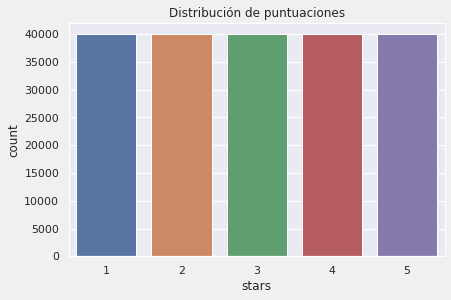

In [14]:
plt.figure()
sns.set(rc={'figure.figsize':(12,8.27)})
plt.title('Distribución de puntuaciones')
sns.countplot(x = "stars", data = ds_train, order = ds_train["stars"].value_counts().index)

In [15]:
# Descripcion en números del grafico anterior
cantidad_s = [] #lista de catidad de productos por categoria
for i in Estrellas:
  total_s = ds_train[(ds_train['stars']==i)].shape[0]
  cantidad_s.append(total_s)

List_s = [round((x / nro_filas)*100,2) for x in cantidad_s]

S = {'Estrellas': Estrellas, 'Nº total por cantidad de Estrellas': cantidad_s,'Porcentaje del total [%]': List_s}
data_total_stars = pd.DataFrame(S)
data_total_stars = data_total_stars.sort_values(by=['Porcentaje del total [%]'], ascending=False, ignore_index=True)

data_total_stars

Estrellas  Nº total por cantidad de Estrellas  Porcentaje del total [%]
0          1                               40000                      20.0
1          2                               40000                      20.0
2          3                               40000                      20.0
3          4                               40000                      20.0
4          5                               40000                      20.0

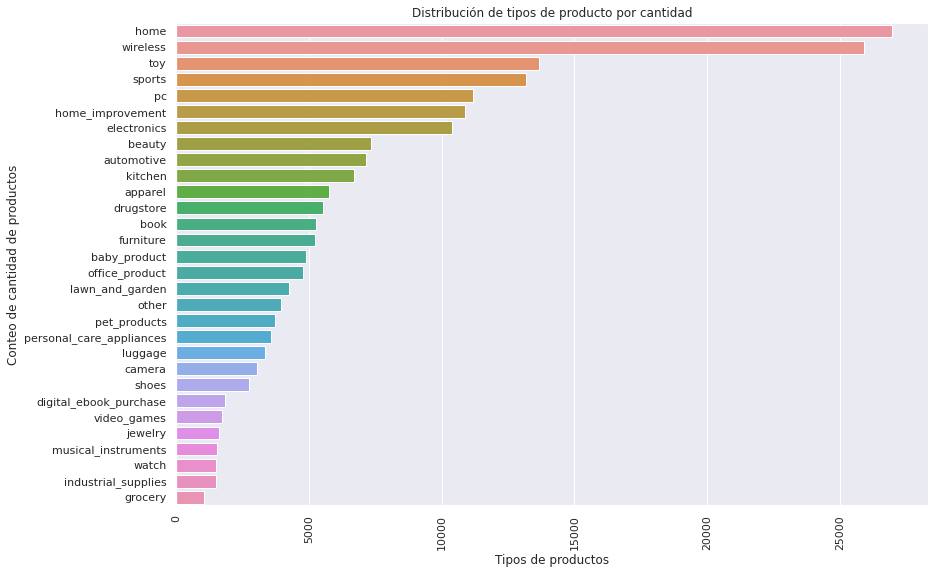

In [16]:
## Distribución por tipos de productos:
plt.figure()
sns.set(rc={'figure.figsize':(12,8.27)})
sns.countplot(y = "product_category", data = ds_train, order = ds_train["product_category"].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Distribución de tipos de producto por cantidad')
plt.xlabel('Tipos de productos')
plt.ylabel('Conteo de cantidad de productos')
plt.show()

In [17]:
# Descripcion en números del grafico anterior
#Cantidad total por tipos de producto:
cantidad = [] #lista de catidad de productos por categoria
for producto in Categorias:
  total = ds_train[(ds_train['product_category']==producto)].shape[0]
  cantidad.append(total)

List = [round((x / nro_filas)*100,2) for x in cantidad]

c = {'Producto': Categorias, 'Nº total por producto': cantidad,'Porcentaje del total [%]': List}
data_total = pd.DataFrame(c)
data_total = data_total.sort_values(by=['Porcentaje del total [%]'], ascending=False, ignore_index=True)

data_total

Producto  Nº total por producto  Porcentaje del total [%]
0                       home                  26962                     13.48
1                   wireless                  25886                     12.94
2                        toy                  13647                      6.82
3                     sports                  13189                      6.59
4                         pc                  11191                      5.60
5           home_improvement                  10879                      5.44
6                electronics                  10385                      5.19
7                     beauty                   7337                      3.67
8                 automotive                   7143                      3.57
9                    kitchen                   6695                      3.35
10                   apparel                   5737                      2.87
11                 drugstore                   5513                      2.76
12                      book                   5264                      2.63
13                 furniture                   5229                      2.61
14              baby_product                   4881                      2.44
15            office_product                   4771                      2.39
16           lawn_and_garden                   4237                      2.12
17                     other                   3937                      1.97
18              pet_products                   3713                      1.86
19  personal_care_appliances                   3573                      1.79
20                   luggage                   3328                      1.66
21                    camera                   3029                      1.51
22                     shoes                   2754                      1.38
23    digital_ebook_purchase                   1843                      0.92
24               video_games                   1733                      0.87
25                   jewelry                   1598                      0.80
26       musical_instruments                   1530                      0.77
27                     watch                   1490                      0.74
28       industrial_supplies                   1482                      0.74
29                   grocery                   1044                      0.52

In [18]:
#Calculo los promedios de puntaje (estrellas) para cada producto:
medias = []
for producto in Categorias:
    datos_productos = ds_train[(ds_train['product_category']==producto)]
    promedio = datos_productos['stars'].mean()
    medias.append(promedio)

m = {'Producto': Categorias, 'Estrellas promedio': medias} #diccionario para crear un df
datos_promedios = pd.DataFrame(m)
datos_promedios = datos_promedios.sort_values(by=['Estrellas promedio'], ascending =False, ignore_index=True)
datos_promedios

Producto  Estrellas promedio
0                       book            3.399316
1     digital_ebook_purchase            3.357027
2                    luggage            3.293570
3        musical_instruments            3.225490
4                    grocery            3.147510
5                video_games            3.124639
6                      shoes            3.109296
7                     camera            3.109277
8               baby_product            3.089326
9             office_product            3.086565
10                     other            3.079756
11       industrial_supplies            3.078947
12                        pc            3.062550
13                 furniture            3.048958
14                       toy            3.042061
15          home_improvement            3.036584
16                    sports            3.034650
17  personal_care_appliances            3.022950
18                   kitchen            3.016281
19                 drugstore            3.010521
20                     watch            3.001342
21              pet_products            2.991112
22                      home            2.980380
23                automotive            2.950721
24                    beauty            2.935805
25                   jewelry            2.930538
26               electronics            2.887626
27                   apparel            2.866829
28                  wireless            2.821834
29           lawn_and_garden            2.773189

**EDA ds_test**

In [19]:
ds_test.head()

review_id          product_id          reviewer_id  stars  \
0  es_0038754  product_es_0113523  reviewer_es_0580071      1   
1  es_0748979  product_es_0017036  reviewer_es_0819733      1   
2  es_0411746  product_es_0138642  reviewer_es_0508607      1   
3  es_0786686  product_es_0170887  reviewer_es_0491157      1   
4  es_0429700  product_es_0710642  reviewer_es_0008745      1   

                                         review_body  \
0  no me llego el articulo me lo mando por correo...   
1              la mensajería horrible, no compro mas   
2  Estoy muy decepcionado con el vendedor ya que ...   
3  Mi valoración no es sobre el producto sino sob...   
4  Pues tenía interés en este libro y probé la ve...   

                                review_title language        product_category  
0                                no me llego       es                wireless  
1   amazon sigue sin cumplir en las entregas       es                    home  
2                         ESTAFA EN EL ENVÍO       es                     toy  
3                           Estafa de Amazon       es                    home  
4  No conseguí pasar de la portada en Kindle       es  digital_ebook_purchase

In [20]:
ds_test.isnull().values.any()

False

In [21]:
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


In [22]:
nro_filas = ds_test.shape[0] #Numero de filas del data set.
idiomas = ds_test.language.unique()#Chequeo que el idioma sea sólo español. 
Categorias = ds_test.product_category.unique() #categorias de productos
Estrellas = ds_test.stars.unique() #cuantas estrellas pueden asignarse? 
print('Tamaño del data set = ', ds_test.shape)
print('-----------------------------------------')
print('Cantidad de registros = ',nro_filas )
print('-----------------------------------------')
print('Idiomas = ',idiomas )
print('-----------------------------------------')
print('Categorías de productos = ',Categorias,",", "Cantidad de categorias = ", len(Categorias)) 
print('-----------------------------------------')
print('Cantidad de estrellas = ',Estrellas )

Tamaño del data set =  (5000, 8)
-----------------------------------------
Cantidad de registros =  5000
-----------------------------------------
Idiomas =  ['es']
-----------------------------------------
Categorías de productos =  ['wireless' 'home' 'toy' 'digital_ebook_purchase' 'pc' 'lawn_and_garden'
 'sports' 'camera' 'home_improvement' 'apparel' 'automotive' 'drugstore'
 'electronics' 'other' 'beauty' 'office_product' 'furniture' 'kitchen'
 'shoes' 'video_games' 'personal_care_appliances' 'pet_products' 'book'
 'jewelry' 'watch' 'luggage' 'baby_product' 'industrial_supplies'
 'musical_instruments' 'grocery'] , Cantidad de categorias =  30
-----------------------------------------
Cantidad de estrellas =  [1 2 3 4 5]


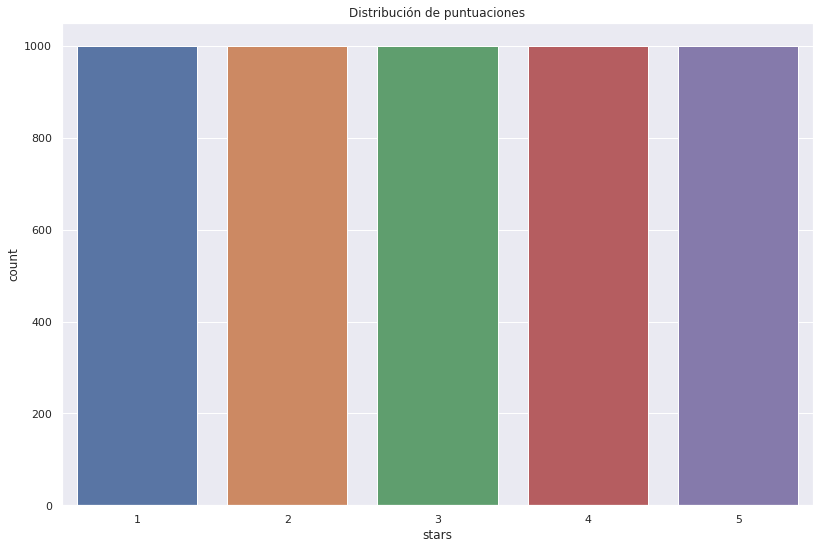

In [23]:
plt.figure()
sns.set(rc={'figure.figsize':(12,8.27)})
plt.title('Distribución de puntuaciones')
sns.countplot(x = "stars", data = ds_test, order = ds_test["stars"].value_counts().index)

In [24]:
# Descripcion en números del grafico anterior
cantidad_s = [] #lista de catidad de productos por categoria
for i in Estrellas:
  total_s = ds_test[(ds_test['stars']==i)].shape[0]
  cantidad_s.append(total_s)

List_s = [round((x / nro_filas)*100,2) for x in cantidad_s]

S = {'Estrellas': Estrellas, 'Nº total por cantidad de Estrellas': cantidad_s,'Porcentaje del total [%]': List_s}
data_total_stars = pd.DataFrame(S)
data_total_stars = data_total_stars.sort_values(by=['Porcentaje del total [%]'], ascending=False, ignore_index=True)

data_total_stars

Estrellas  Nº total por cantidad de Estrellas  Porcentaje del total [%]
0          1                                1000                      20.0
1          2                                1000                      20.0
2          3                                1000                      20.0
3          4                                1000                      20.0
4          5                                1000                      20.0

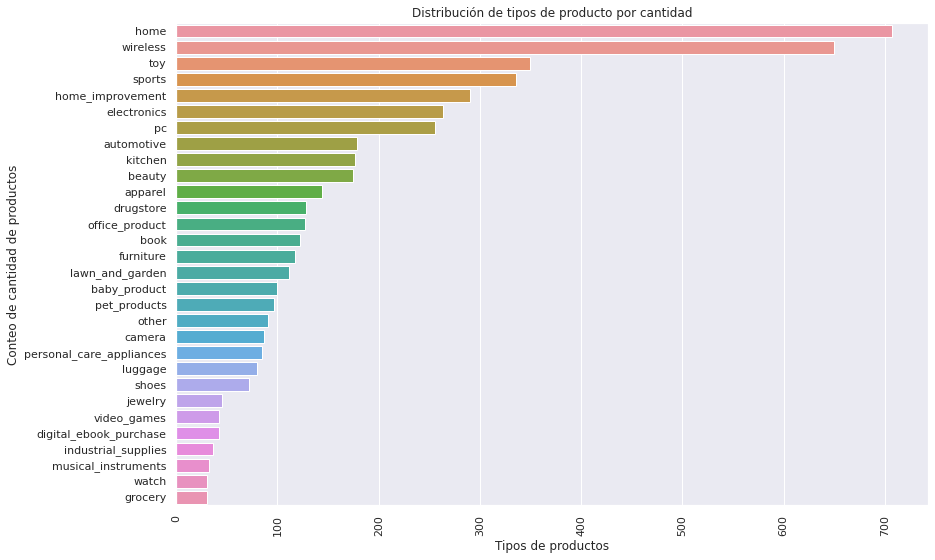

In [25]:
## Distribución por tipos de productos:
plt.figure()
sns.set(rc={'figure.figsize':(12,8.27)})
sns.countplot(y = "product_category", data = ds_test, order = ds_test["product_category"].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Distribución de tipos de producto por cantidad')
plt.xlabel('Tipos de productos')
plt.ylabel('Conteo de cantidad de productos')
plt.show()

In [26]:
# Descripcion en números del grafico anterior
#Cantidad total por tipos de producto:
cantidad = [] #lista de catidad de productos por categoria
for producto in Categorias:
  total = ds_test[(ds_test['product_category']==producto)].shape[0]
  cantidad.append(total)

List = [round((x / nro_filas)*100,2) for x in cantidad]

c = {'Producto': Categorias, 'Nº total por producto': cantidad,'Porcentaje del total [%]': List}
data_total = pd.DataFrame(c)
data_total = data_total.sort_values(by=['Porcentaje del total [%]'], ascending=False, ignore_index=True)

data_total

Producto  Nº total por producto  Porcentaje del total [%]
0                       home                    707                     14.14
1                   wireless                    650                     13.00
2                        toy                    349                      6.98
3                     sports                    336                      6.72
4           home_improvement                    290                      5.80
5                electronics                    263                      5.26
6                         pc                    256                      5.12
7                 automotive                    179                      3.58
8                    kitchen                    177                      3.54
9                     beauty                    175                      3.50
10                   apparel                    144                      2.88
11                 drugstore                    128                      2.56
12            office_product                    127                      2.54
13                      book                    122                      2.44
14                 furniture                    117                      2.34
15           lawn_and_garden                    111                      2.22
16              baby_product                    100                      2.00
17              pet_products                     97                      1.94
18                     other                     91                      1.82
19                    camera                     87                      1.74
20  personal_care_appliances                     85                      1.70
21                   luggage                     80                      1.60
22                     shoes                     72                      1.44
23                   jewelry                     45                      0.90
24               video_games                     42                      0.84
25    digital_ebook_purchase                     42                      0.84
26       industrial_supplies                     36                      0.72
27       musical_instruments                     32                      0.64
28                     watch                     30                      0.60
29                   grocery                     30                      0.60

In [27]:
#Calculo los promedios de puntaje (estrellas) para cada producto:
medias = []
for producto in Categorias:
    datos_productos = ds_test[(ds_test['product_category']==producto)]
    promedio = datos_productos['stars'].mean()
    medias.append(promedio)

m = {'Producto': Categorias, 'Estrellas promedio': medias} #diccionario para crear un df
datos_promedios = pd.DataFrame(m)
datos_promedios = datos_promedios.sort_values(by=['Estrellas promedio'], ascending =False, ignore_index=True)
datos_promedios

Producto  Estrellas promedio
0                       book            3.680328
1                    grocery            3.400000
2        musical_instruments            3.343750
3     digital_ebook_purchase            3.333333
4                    luggage            3.300000
5                 automotive            3.256983
6                  furniture            3.239316
7             office_product            3.188976
8                         pc            3.175781
9               baby_product            3.170000
10  personal_care_appliances            3.082353
11                      home            3.077793
12              pet_products            3.072165
13               video_games            3.023810
14          home_improvement            3.006897
15                     other            3.000000
16                       toy            2.988539
17                    beauty            2.931429
18                    camera            2.931034
19                   kitchen            2.909605
20                     shoes            2.902778
21                    sports            2.901786
22               electronics            2.893536
23                   apparel            2.875000
24       industrial_supplies            2.861111
25                 drugstore            2.789062
26                  wireless            2.784615
27                   jewelry            2.733333
28                     watch            2.733333
29           lawn_and_garden            2.459459

**EDA ds_dev**

In [28]:
ds_dev.head()

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  
0                         Mala compra       es          wireless  
1                   No lo he recibido       es           apparel  
2  Que no aprieta bien en el manillar       es            sports  
3               Brocas de mantequilla       es  home_improvement  
4                         No me gusta       es            beauty

In [29]:
ds_dev.isnull().values.any()

False

In [30]:
ds_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


In [31]:
nro_filas = ds_dev.shape[0] #Numero de filas del data set.
idiomas = ds_dev.language.unique()#Chequeo que el idioma sea sólo español. 
Categorias = ds_dev.product_category.unique() #categorias de productos
Estrellas = ds_dev.stars.unique() #cuantas estrellas pueden asignarse? 
print('Tamaño del data set = ', ds_dev.shape)
print('-----------------------------------------')
print('Cantidad de registros = ',nro_filas )
print('-----------------------------------------')
print('Idiomas = ',idiomas )
print('-----------------------------------------')
print('Categorías de productos = ',Categorias,",", "Cantidad de categorias = ", len(Categorias)) 
print('-----------------------------------------')
print('Cantidad de estrellas = ',Estrellas )

Tamaño del data set =  (5000, 8)
-----------------------------------------
Cantidad de registros =  5000
-----------------------------------------
Idiomas =  ['es']
-----------------------------------------
Categorías de productos =  ['wireless' 'apparel' 'sports' 'home_improvement' 'beauty' 'home'
 'baby_product' 'pc' 'toy' 'book' 'personal_care_appliances' 'kitchen'
 'lawn_and_garden' 'pet_products' 'drugstore' 'office_product' 'furniture'
 'electronics' 'automotive' 'shoes' 'jewelry' 'luggage' 'camera'
 'industrial_supplies' 'other' 'musical_instruments' 'grocery'
 'digital_ebook_purchase' 'video_games' 'watch'] , Cantidad de categorias =  30
-----------------------------------------
Cantidad de estrellas =  [1 2 3 4 5]


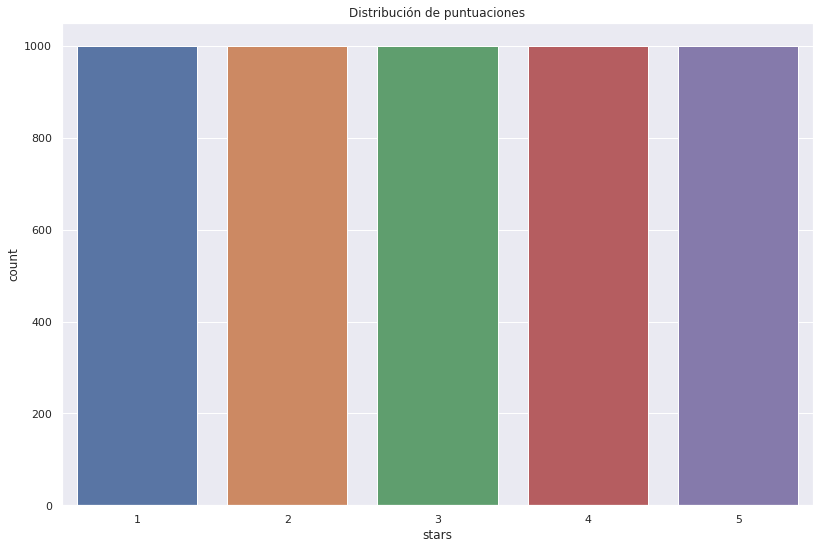

In [32]:
plt.figure()
sns.set(rc={'figure.figsize':(12,8.27)})
plt.title('Distribución de puntuaciones')
sns.countplot(x = "stars", data = ds_dev, order = ds_dev["stars"].value_counts().index)

In [33]:
# Descripcion en números del grafico anterior
cantidad_s = [] #lista de catidad de productos por categoria
for i in Estrellas:
  total_s = ds_dev[(ds_dev['stars']==i)].shape[0]
  cantidad_s.append(total_s)

List_s = [round((x / nro_filas)*100,2) for x in cantidad_s]

S = {'Estrellas': Estrellas, 'Nº total por cantidad de Estrellas': cantidad_s,'Porcentaje del total [%]': List_s}
data_total_stars = pd.DataFrame(S)
data_total_stars = data_total_stars.sort_values(by=['Porcentaje del total [%]'], ascending=False, ignore_index=True)

data_total_stars

Estrellas  Nº total por cantidad de Estrellas  Porcentaje del total [%]
0          1                                1000                      20.0
1          2                                1000                      20.0
2          3                                1000                      20.0
3          4                                1000                      20.0
4          5                                1000                      20.0

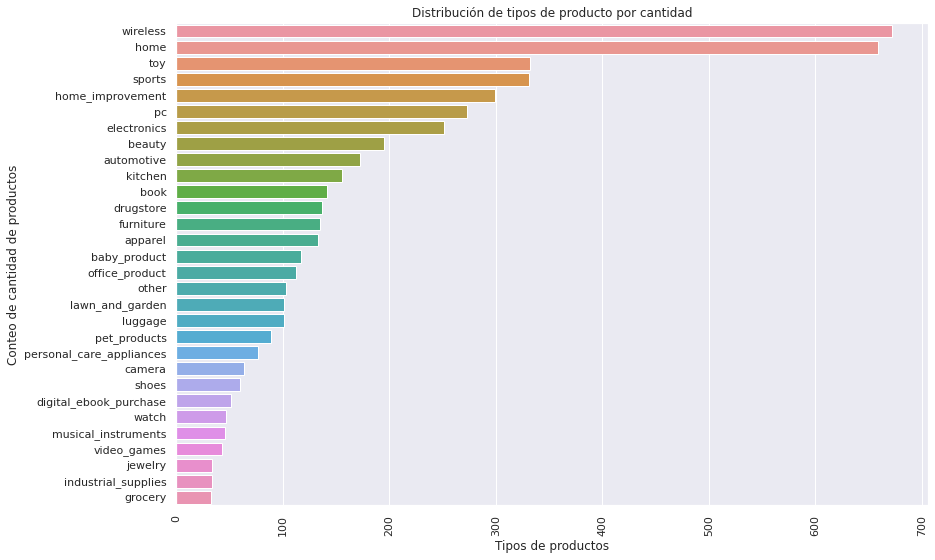

In [34]:
## Distribución por tipos de productos:
plt.figure()
sns.set(rc={'figure.figsize':(12,8.27)})
sns.countplot(y = "product_category", data = ds_dev, order = ds_dev["product_category"].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Distribución de tipos de producto por cantidad')
plt.xlabel('Tipos de productos')
plt.ylabel('Conteo de cantidad de productos')
plt.show()

In [35]:
# Descripcion en números del grafico anterior
#Cantidad total por tipos de producto:
cantidad = [] #lista de catidad de productos por categoria
for producto in Categorias:
  total = ds_dev[(ds_dev['product_category']==producto)].shape[0]
  cantidad.append(total)

List = [round((x / nro_filas)*100,2) for x in cantidad]

c = {'Producto': Categorias, 'Nº total por producto': cantidad,'Porcentaje del total [%]': List}
data_total = pd.DataFrame(c)
data_total = data_total.sort_values(by=['Porcentaje del total [%]'], ascending=False, ignore_index=True)

data_total

Producto  Nº total por producto  Porcentaje del total [%]
0                   wireless                    672                     13.44
1                       home                    659                     13.18
2                        toy                    332                      6.64
3                     sports                    331                      6.62
4           home_improvement                    299                      5.98
5                         pc                    273                      5.46
6                electronics                    251                      5.02
7                     beauty                    195                      3.90
8                 automotive                    173                      3.46
9                    kitchen                    156                      3.12
10                      book                    142                      2.84
11                 drugstore                    137                      2.74
12                 furniture                    135                      2.70
13                   apparel                    133                      2.66
14              baby_product                    117                      2.34
15            office_product                    112                      2.24
16                     other                    103                      2.06
17           lawn_and_garden                    101                      2.02
18                   luggage                    101                      2.02
19              pet_products                     89                      1.78
20  personal_care_appliances                     77                      1.54
21                    camera                     64                      1.28
22                     shoes                     60                      1.20
23    digital_ebook_purchase                     51                      1.02
24                     watch                     47                      0.94
25       musical_instruments                     46                      0.92
26               video_games                     43                      0.86
27                   jewelry                     34                      0.68
28       industrial_supplies                     34                      0.68
29                   grocery                     33                      0.66

In [36]:
#Calculo los promedios de puntaje (estrellas) para cada producto:
medias = []
for producto in Categorias:
    datos_productos = ds_dev[(ds_dev['product_category']==producto)]
    promedio = datos_productos['stars'].mean()
    medias.append(promedio)

m = {'Producto': Categorias, 'Estrellas promedio': medias} #diccionario para crear un df
datos_promedios = pd.DataFrame(m)
datos_promedios = datos_promedios.sort_values(by=['Estrellas promedio'], ascending =False, ignore_index=True)
datos_promedios

Producto  Estrellas promedio
0     digital_ebook_purchase            3.529412
1                       book            3.373239
2                    grocery            3.333333
3                    luggage            3.287129
4                      other            3.252427
5                         pc            3.150183
6                    jewelry            3.147059
7               pet_products            3.134831
8                  furniture            3.133333
9                     beauty            3.128205
10                   kitchen            3.051282
11  personal_care_appliances            3.038961
12               electronics            3.031873
13                   apparel            2.984962
14              baby_product            2.982906
15                 drugstore            2.970803
16                    sports            2.969789
17                    camera            2.968750
18                      home            2.968134
19                       toy            2.966867
20                     watch            2.957447
21            office_product            2.955357
22          home_improvement            2.939799
23                     shoes            2.933333
24               video_games            2.930233
25       industrial_supplies            2.911765
26                automotive            2.849711
27                  wireless            2.845238
28           lawn_and_garden            2.673267
29       musical_instruments            2.652174

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Una vez realizado el EDA de cada DS, trabajamos en el ds_train (mayor canyidad de datos y, segun lo arrojado antes, son homogeneos.**




**Frecuencia de palabras**

Frecuencia de las palabras según puntuación = 

In [37]:
'''
NO ME HACE EL LOOP, voy a hacerlo estrella por estrella

stars = [1,2,3,4,5]
#stars = [1]
#Elegir si quedarme con todas las categorías de productos o sólo con las más populares
#ds_train = ds_train[(ds_train['product_category'].isin(('home','wireless','toy')))]
#o sólo la más popular:
#ds_train = ds_train[(ds_train['product_category'] == 'home')]

for i in stars:
  datos = ds_train[(ds_train.stars == i)]  #Tomo las peores/mejores reviews.
  datos_reseñas = datos[['review_body','stars']] #utilizo esas dos columnas.
  #print(datos_malo.shape) # Tomo 20% del DS de train.
  datos_reseñas.head()
  '''


"\nNO ME HACE EL LOOP, voy a hacerlo estrella por estrella\n\nstars = [1,2,3,4,5]\n#stars = [1]\n#Elegir si quedarme con todas las categorías de productos o sólo con las más populares\n#ds_train = ds_train[(ds_train['product_category'].isin(('home','wireless','toy')))]\n#o sólo la más popular:\n#ds_train = ds_train[(ds_train['product_category'] == 'home')]\n\nfor i in stars:\n  datos = ds_train[(ds_train.stars == i)]  #Tomo las peores/mejores reviews.\n  datos_reseñas = datos[['review_body','stars']] #utilizo esas dos columnas.\n  #print(datos_malo.shape) # Tomo 20% del DS de train.\n  datos_reseñas.head()\n  "

In [38]:
## Puntuacion 1
datos = ds_train[(ds_train.stars == 1)]  #Tomo las peores/mejores reviews.
datos_reseñas = datos[['review_body','stars']] #utilizo esas dos columnas.
#print(datos_malo.shape) # Tomo 20% del DS de train.
print("------------------------------------------------------------------------")
print('Puntuación: 1 estrella')
print("------------------------------------------------------------------------")
datos_reseñas.head()

------------------------------------------------------------------------
Puntuación: 1 estrella
------------------------------------------------------------------------


review_body  stars
0  Nada bueno se me fue ka pantalla en menos de 8...      1
1  Horrible, nos tuvimos que comprar otro porque ...      1
2  Te obligan a comprar dos unidades y te llega s...      1
3  No entro en descalificar al vendedor, solo pue...      1
4               Llega tarde y co la talla equivocada      1

**Tokenizacion**

In [39]:
tokenizer = RegexpTokenizer(r'\w+') #r'\w+' #crea tokenizador.
  
reseñas_1 = []
for i in range(datos_reseñas.shape[0]):
      reseña = datos_reseñas['review_body'].iloc[i] #selecciona cada reseña
      reseña = reseña.lower() #paso a minusculas.
      reseña = re.sub(r'\d+','', reseña)#quito los numeros.
      reseña =  tokenizer.tokenize(reseña) #Tokeniza
      reseña = [palabra for palabra in reseña if len(palabra)>2] #Quito las palabras de menos de 3 letras
      # Filtrar stopwords
      reseña_sin_sw = []
      for palabra in reseña:
          if palabra not in stops:
             reseña_sin_sw.append(palabra)
      reseñas_1.append(reseña_sin_sw) #agregar el resultado a la lista

In [40]:
reseñas_1 = list(itertools.chain(*reseñas_1)) #convierte una lista de listas en una unica lista
freq_reseñas_1 = nltk.FreqDist(reseñas_1) # Reviso la frecuencia de las palabras de los titulos.
freq_reseñas_1 = dict(freq_reseñas_1) #Frecuencia de palabras en reseñas 1

In [41]:
#freq_reseñas_1

In [42]:
df_1 = pd.DataFrame(freq_reseñas_1.items()) # aplico metodo items() = los valores devueltos por ese método son tuplas de la clave y el valor.
df_1.columns = ['Term','Frequency']
df_reseñas_1 = df_1
df_reseñas_1.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar de mayor a menor por frecuencia
df_reseñas_1.reset_index(drop = True, inplace=True) #resetea el indice
df_reseñas_1.head(10)

Term  Frequency
0    producto       7219
1        bien       4448
2     calidad       4349
3     llegado       3422
4         dos       3328
5         mal       2868
6  recomiendo       2812
7      amazon       2749
8        mala       2587
9    funciona       2582

Puntuación: 1


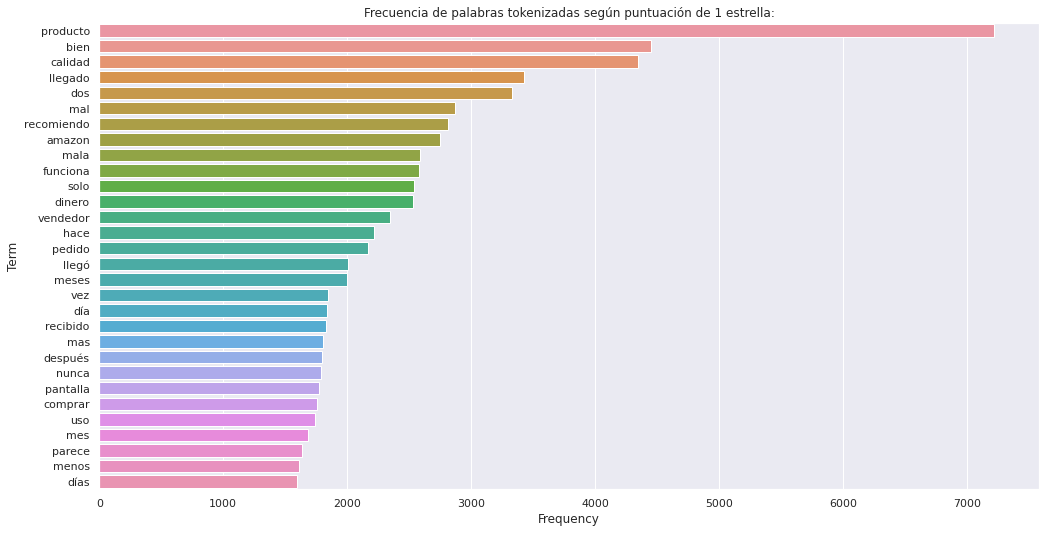

Cantidad de reseñas:  27007


In [43]:
# Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_reseñas_1['Term'].iloc[:30], x = df_reseñas_1['Frequency'].iloc[:30])
print('Puntuación: 1')
plt.title('Frecuencia de palabras tokenizadas según puntuación de 1 estrella:')
plt.show()
print('Cantidad de reseñas: ', df_reseñas_1.shape[0]) # 


    

Puntuación: 2


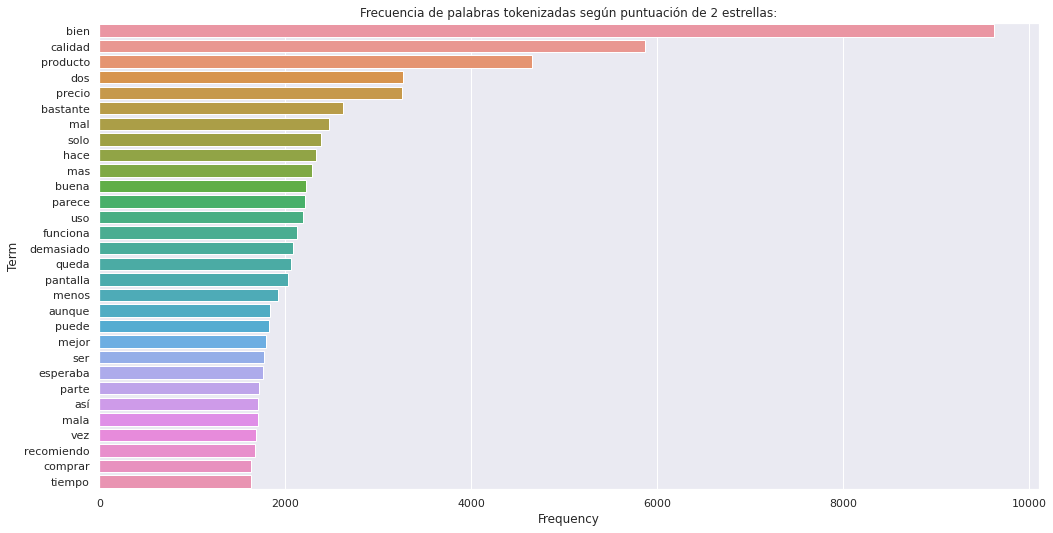

Cantidad de reseñas:  29691

2 Estrellas



Term  Frequency
0      bien       9627
1   calidad       5874
2  producto       4651
3       dos       3262
4    precio       3253
5  bastante       2618
6       mal       2476
7      solo       2385
8      hace       2336
9       mas       2292

In [44]:
#puntuacion 2

#stars = [2]
#Elegir si quedarme con todas las categorías de productos o sólo con las más populares
#ds_train = ds_train[(ds_train['product_category'].isin(('home','wireless','toy')))]
#o sólo la más popular:
#ds_train = ds_train[(ds_train['product_category'] == 'home')]

#for star in stars:
datos = ds_train[(ds_train.stars == 2)] 
datos_reseñas = datos[['review_body','stars']] 


reseñas_2 = []
for i in range(datos_reseñas.shape[0]):
      reseña = datos_reseñas['review_body'].iloc[i] #selecciona cada reseña
      reseña = reseña.lower() #paso a minusculas.
      reseña = re.sub(r'\d+','', reseña)#quito los numeros.
      reseña =  tokenizer.tokenize(reseña) #Tokeniza
      reseña = [palabra for palabra in reseña if len(palabra)>2] #Quito las palabras de menos de 3 letras
      # Filtrar stopwords
      reseña_sin_sw = []
      for palabra in reseña:
          if palabra not in stops:
             reseña_sin_sw.append(palabra)
      reseñas_2.append(reseña_sin_sw) #agregar el resultado a la lista

reseñas_2 = list(itertools.chain(*reseñas_2)) #convierte una lista de listas en una unica lista
freq_reseñas_2 = nltk.FreqDist(reseñas_2) # Reviso la frecuencia de las palabras de los titulos.
freq_reseñas_2 = dict(freq_reseñas_2) #Frecuencia de palabras en reseñas 2

#armo DF
df_2 = pd.DataFrame(freq_reseñas_2.items()) # aplico metodo items() = los valores devueltos por ese método son tuplas de la clave y el valor.
df_2.columns = ['Term','Frequency']
df_reseñas_2 = df_2
df_reseñas_2.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar de mayor a menor por frecuencia
df_reseñas_2.reset_index(drop = True, inplace=True) #resetea el indice
#df_reseñas_2.head(20)

# Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_reseñas_2['Term'].iloc[:30], x = df_reseñas_2['Frequency'].iloc[:30])
print('Puntuación: 2')
plt.title('Frecuencia de palabras tokenizadas según puntuación de 2 estrellas:')
plt.show()
print('Cantidad de reseñas: ', df_reseñas_2.shape[0]) # 
print('')
print('2 Estrellas')
print('')
df_reseñas_2.head(10)

Puntuación: 3


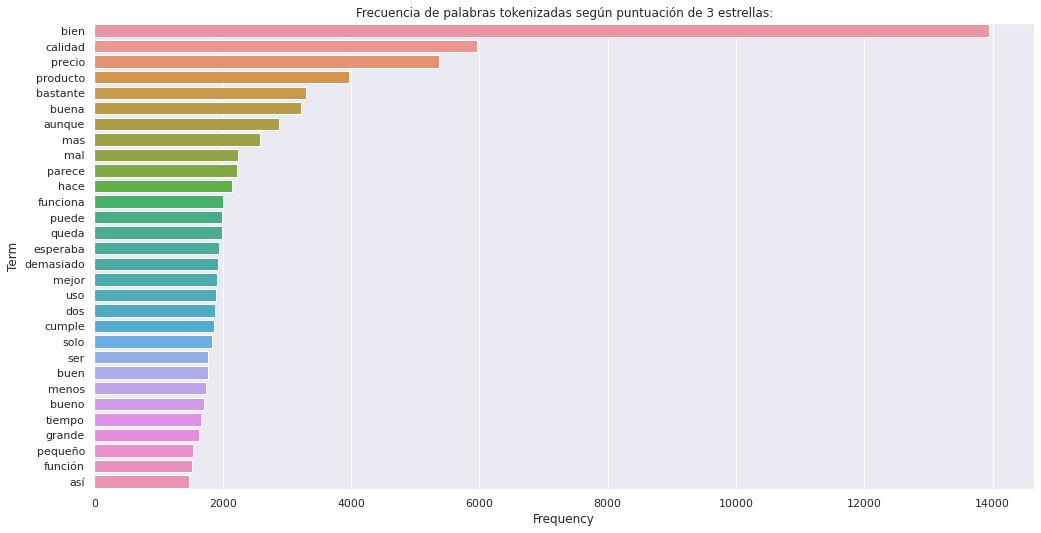

Cantidad de reseñas:  28711

3 Estrellas



Term  Frequency
0      bien      13948
1   calidad       5967
2    precio       5376
3  producto       3973
4  bastante       3299
5     buena       3223
6    aunque       2882
7       mas       2588
8       mal       2242
9    parece       2223

In [45]:
#puntuacion 3

#stars = [3]
#Elegir si quedarme con todas las categorías de productos o sólo con las más populares
#ds_train = ds_train[(ds_train['product_category'].isin(('home','wireless','toy')))]
#o sólo la más popular:
#ds_train = ds_train[(ds_train['product_category'] == 'home')]

#for star in stars:
datos = ds_train[(ds_train.stars == 3)] 
datos_reseñas = datos[['review_body','stars']] 


reseñas_3 = []
for i in range(datos_reseñas.shape[0]):
      reseña = datos_reseñas['review_body'].iloc[i] #selecciona cada reseña
      reseña = reseña.lower() #paso a minusculas.
      reseña = re.sub(r'\d+','', reseña)#quito los numeros.
      reseña =  tokenizer.tokenize(reseña) #Tokeniza
      reseña = [palabra for palabra in reseña if len(palabra)>2] #Quito las palabras de menos de 3 letras
      # Filtrar stopwords
      reseña_sin_sw = []
      for palabra in reseña:
          if palabra not in stops:
             reseña_sin_sw.append(palabra)
      reseñas_3.append(reseña_sin_sw) #agregar el resultado a la lista

reseñas_3 = list(itertools.chain(*reseñas_3)) #convierte una lista de listas en una unica lista
freq_reseñas_3 = nltk.FreqDist(reseñas_3) # Reviso la frecuencia de las palabras de los titulos.
freq_reseñas_3 = dict(freq_reseñas_3) #Frecuencia de palabras en reseñas 2

#armo DF
df_3 = pd.DataFrame(freq_reseñas_3.items()) # aplico metodo items() = los valores devueltos por ese método son tuplas de la clave y el valor.
df_3.columns = ['Term','Frequency']
df_reseñas_3 = df_3
df_reseñas_3.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar de mayor a menor por frecuencia
df_reseñas_3.reset_index(drop = True, inplace=True) #resetea el indice
#df_reseñas_3.head(20)

# Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_reseñas_3['Term'].iloc[:30],x = df_reseñas_3['Frequency'].iloc[:30])
print('Puntuación: 3')
plt.title('Frecuencia de palabras tokenizadas según puntuación de 3 estrellas:')

plt.show()
print('Cantidad de reseñas: ', df_reseñas_3.shape[0]) # 
print('')
print('3 Estrellas')
print('')
df_reseñas_3.head(10)

Puntuación: 4


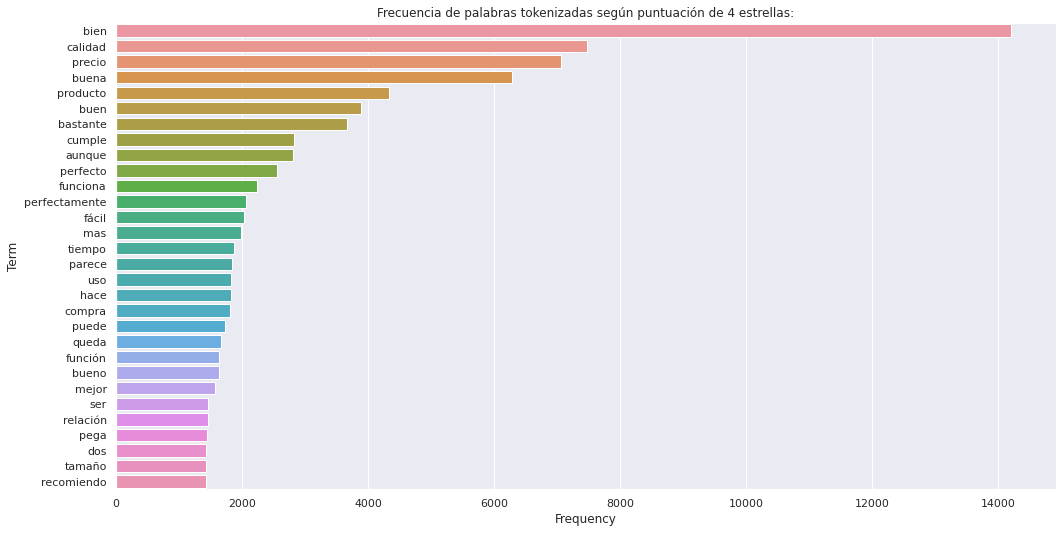

Cantidad de reseñas:  27107

4 Estrellas



Term  Frequency
0      bien      14206
1   calidad       7476
2    precio       7063
3     buena       6278
4  producto       4332
5      buen       3892
6  bastante       3660
7    cumple       2821
8    aunque       2802
9  perfecto       2559

In [46]:
#Puntuacion 4
#stars = [4]
#Elegir si quedarme con todas las categorías de productos o sólo con las más populares
#ds_train = ds_train[(ds_train['product_category'].isin(('home','wireless','toy')))]
#o sólo la más popular:
#ds_train = ds_train[(ds_train['product_category'] == 'home')]

#for star in stars:
datos = ds_train[(ds_train.stars == 4)] 
datos_reseñas = datos[['review_body','stars']] 


reseñas_4 = []
for i in range(datos_reseñas.shape[0]):
      reseña = datos_reseñas['review_body'].iloc[i] #selecciona cada reseña
      reseña = reseña.lower() #paso a minusculas.
      reseña = re.sub(r'\d+','', reseña)#quito los numeros.
      reseña =  tokenizer.tokenize(reseña) #Tokeniza
      reseña = [palabra for palabra in reseña if len(palabra)>2] #Quito las palabras de menos de 3 letras
      # Filtrar stopwords
      reseña_sin_sw = []
      for palabra in reseña:
          if palabra not in stops:
             reseña_sin_sw.append(palabra)
      reseñas_4.append(reseña_sin_sw) #agregar el resultado a la lista

reseñas_4 = list(itertools.chain(*reseñas_4)) #convierte una lista de listas en una unica lista
freq_reseñas_4 = nltk.FreqDist(reseñas_4) # Reviso la frecuencia de las palabras de los titulos.
freq_reseñas_4 = dict(freq_reseñas_4) #Frecuencia de palabras en reseñas 2

#armo DF
df_4= pd.DataFrame(freq_reseñas_4.items()) # aplico metodo items() = los valores devueltos por ese método son tuplas de la clave y el valor.
df_4.columns = ['Term','Frequency']
df_reseñas_4 = df_4
df_reseñas_4.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar de mayor a menor por frecuencia
df_reseñas_4.reset_index(drop = True, inplace=True) #resetea el indice
#df_reseñas_3.head(20)

# Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_reseñas_4['Term'].iloc[:30], x = df_reseñas_4['Frequency'].iloc[:30])
print('Puntuación: 4')
plt.title('Frecuencia de palabras tokenizadas según puntuación de 4 estrellas:')

plt.show()
print('Cantidad de reseñas: ', df_reseñas_4.shape[0]) # 
print('')
print('4 Estrellas')
print('')
df_reseñas_4.head(10)

Puntuación: 5


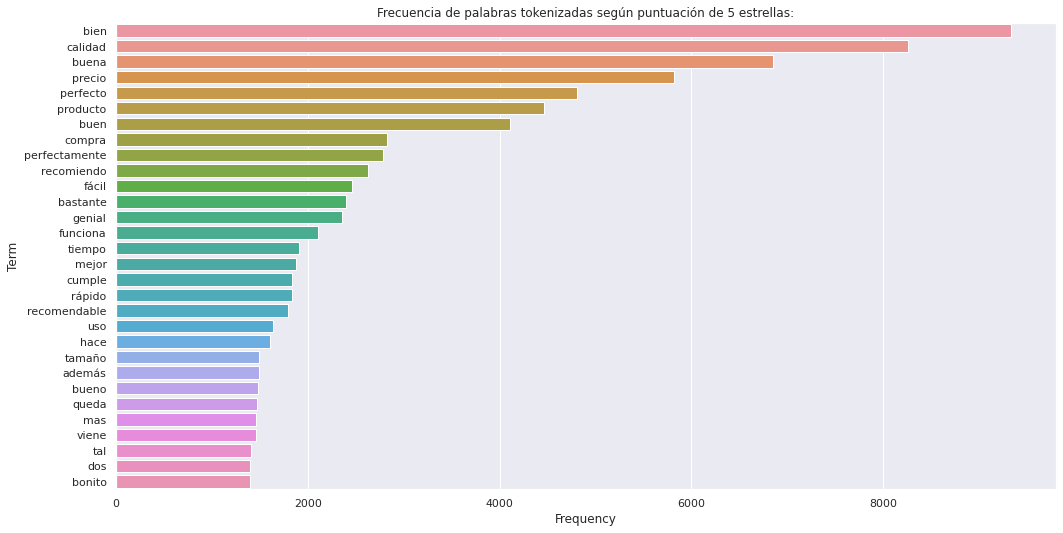

Cantidad de reseñas:  26647

5 Estrellas



Term  Frequency
0           bien       9333
1        calidad       8263
2          buena       6852
3         precio       5813
4       perfecto       4809
5       producto       4459
6           buen       4107
7         compra       2827
8  perfectamente       2778
9     recomiendo       2631

In [47]:
#untucion 5
#stars = [5]
#Elegir si quedarme con todas las categorías de productos o sólo con las más populares
#ds_train = ds_train[(ds_train['product_category'].isin(('home','wireless','toy')))]
#o sólo la más popular:
#ds_train = ds_train[(ds_train['product_category'] == 'home')]

#for star in stars:
datos = ds_train[(ds_train.stars == 5)] 
datos_reseñas = datos[['review_body','stars']] 


reseñas_5 = []
for i in range(datos_reseñas.shape[0]):
      reseña = datos_reseñas['review_body'].iloc[i] #selecciona cada reseña
      reseña = reseña.lower() #paso a minusculas.
      reseña = re.sub(r'\d+','', reseña)#quito los numeros.
      reseña =  tokenizer.tokenize(reseña) #Tokeniza
      reseña = [palabra for palabra in reseña if len(palabra)>2] #Quito las palabras de menos de 3 letras
      # Filtrar stopwords
      reseña_sin_sw = []
      for palabra in reseña:
          if palabra not in stops:
             reseña_sin_sw.append(palabra)
      reseñas_5.append(reseña_sin_sw) #agregar el resultado a la lista

reseñas_5 = list(itertools.chain(*reseñas_5)) #convierte una lista de listas en una unica lista
freq_reseñas_5 = nltk.FreqDist(reseñas_5) # Reviso la frecuencia de las palabras de los titulos.
freq_reseñas_5 = dict(freq_reseñas_5) #Frecuencia de palabras en reseñas 2

#armo DF
df_5 = pd.DataFrame(freq_reseñas_5.items()) # aplico metodo items() = los valores devueltos por ese método son tuplas de la clave y el valor.
df_5.columns = ['Term','Frequency']
df_reseñas_5 = df_5
df_reseñas_5.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar de mayor a menor por frecuencia
df_reseñas_5.reset_index(drop = True, inplace=True) #resetea el indice
#df_reseñas_5.head(20)

# Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_reseñas_5['Term'].iloc[:30], x = df_reseñas_5['Frequency'].iloc[:30])
print('Puntuación: 5')
plt.title('Frecuencia de palabras tokenizadas según puntuación de 5 estrellas:')
plt.show()
print('Cantidad de reseñas: ', df_reseñas_5.shape[0]) # 
print('')
print('5 Estrellas')
print('')
df_reseñas_5.head(10)

In [48]:
cruza = pd.concat([df_reseñas_1, df_reseñas_2, df_reseñas_3, df_reseñas_4, df_reseñas_5], axis=1)
cruza.head(10)

Term  Frequency      Term  Frequency      Term  Frequency      Term  \
0    producto     7219.0      bien       9627      bien    13948.0      bien   
1        bien     4448.0   calidad       5874   calidad     5967.0   calidad   
2     calidad     4349.0  producto       4651    precio     5376.0    precio   
3     llegado     3422.0       dos       3262  producto     3973.0     buena   
4         dos     3328.0    precio       3253  bastante     3299.0  producto   
5         mal     2868.0  bastante       2618     buena     3223.0      buen   
6  recomiendo     2812.0       mal       2476    aunque     2882.0  bastante   
7      amazon     2749.0      solo       2385       mas     2588.0    cumple   
8        mala     2587.0      hace       2336       mal     2242.0    aunque   
9    funciona     2582.0       mas       2292    parece     2223.0  perfecto   

   Frequency           Term  Frequency  
0    14206.0           bien     9333.0  
1     7476.0        calidad     8263.0  
2     7063.0          buena     6852.0  
3     6278.0         precio     5813.0  
4     4332.0       perfecto     4809.0  
5     3892.0       producto     4459.0  
6     3660.0           buen     4107.0  
7     2821.0         compra     2827.0  
8     2802.0  perfectamente     2778.0  
9     2559.0     recomiendo     2631.0

**Hasta aquí:  **

El ds_train tiene 200000 registros en idioma español, no tiene valores faltantes.
Cada registro es una reseña que, más allá del contenido de la misma puntúa el producto, que son 30 categorías, otorgando estrellas, de 1 a 5, siendo 1 lo peor y 5 lo mejor.

La distribución de los datos en 'stars' uniforme: si se ve en el grafico, cada una de las opciones tiene la misma cantidad de registros (40000).

De las categorías de productos, tenemos que los más buscados o reseñados son 'Home', con un 13.4 %, seguido de 'wireless', con un 12.9%.

En cuanto a la frecuencia, las palabras que más se repiten son similares en todos los clusters de puntuacion (tener en cuenta que sólo se hizo una normalizació): 
 1 estrella:

'producto' 7219 veces.
'bien' 4448 veces.
'calidad' 4349 veces.

2 estrellas:

 'bien' 59627 veces
 'calidad' 5874 veces
 'producto' 4651 veces

3 estrellas:

 'bien' 13948 veces
 'calidad' 5967 veces
 'producto' 3973 veces

4 estrellas:

 'bien' 14206 veces
 'calidad' 7476 veces
 'producto' 4332 veces

5 estrellas:

 'bien' 9333 veces
 'calidad' 8263 veces
 'producto' 4459 veces

En terminos comparativos, las palabras que más se repiten son 'bien', 'calidad' y 'producto'. 
Por una parte, no podemos perder de vista el rol de cada palabra = puede corresponder a un concepto que hace referencia a un atributo positivo, por ejemplo, 'buena calidad'o lo contrario, 'mala calidad' (la palabra 'mal' sólo se encuentra con mayor frecuencia en las reseñas de 1, 2 y 3 estrellas), por lo que se hace necesario profundizar mas en este sentido. 
por otra arte, bien podría pensarse en la opción de eliminar del corpus esas palabras
 


**-------------------------------------------------------------------------------------------------------------------------------------------------------**

**Stemming**

**-------------------------------------------------------------------------------------------------------------------------------------------------------**

In [49]:
from locale import ABMON_3

stars = [1,2,3,4,5]
stemm_español = SnowballStemmer('spanish')
#wordnet_lemmatizer = WordNetLemmatizer('Spanish') #NO TIENE SPANISH
tokenizer = RegexpTokenizer(r'\w+') #Inicializo tokenizador.

for star in stars:
  datos_reseña = ds_train[(ds_train.stars == star)]  #Tomo las peores/mejores reviews.
  datos = datos_reseña[['review_body','stars']]        #Me quedo con el cuerpo de la review y el puntaje.
  print(datos.shape) # Tomo 20% del DS de train.
  print('')
  print(datos.head())
  print('')
  print('----------------------------------------------------------')

  

(40000, 2)

                                         review_body  stars
0  Nada bueno se me fue ka pantalla en menos de 8...      1
1  Horrible, nos tuvimos que comprar otro porque ...      1
2  Te obligan a comprar dos unidades y te llega s...      1
3  No entro en descalificar al vendedor, solo pue...      1
4               Llega tarde y co la talla equivocada      1

----------------------------------------------------------
(40000, 2)

                                             review_body  stars
40000  Los tornillos no ajustan bien, se caen. No lo ...      2
40001  Si haces varias impresiones seguidas aparecen ...      2
40002      es pequeño no coincide con la pantalla del a1      2
40003  No lleva nada para trasportarla y es un poco r...      2
40004  a ver si me explico , su software reconoce las...      2

----------------------------------------------------------
(40000, 2)

                                             review_body  stars
80000  cabe bien un móvil de 5,5 y c

In [50]:
'''
## Comienzo a procesar las reviews y calculo la frecuencia para las malas:
todos_reseñas_ = []
for i in range(datos.shape[0]):
    review = datos['review_body'].iloc[i] #seleccionar cada reseña
    review = review.lower() # paso a minusculas a minusculas.
    review = re.sub(r'\d+','', review) #saco numeros
    review =  tokenizer.tokenize(review)  #Tokenizo
    review = [palabra for palabra in review if len(palabra)>2] #Elimino las palabras de menos de 3 letras.
    review = [stemm_español.stem(w) for w in review]   #Stemming de reseñas.
      # Filtrar por stopwords
    reseña_sin_sw = []
    for palabra in review:
        if palabra not in stops:
            reseña_sin_sw.append(palabra)
    todos_reseñas_.append(reseña_sin_sw) #agregar el resultado a la lista
      
'''

"\n## Comienzo a procesar las reviews y calculo la frecuencia para las malas:\ntodos_reseñas_ = []\nfor i in range(datos.shape[0]):\n    review = datos['review_body'].iloc[i] #seleccionar cada reseña\n    review = review.lower() # paso a minusculas a minusculas.\n    review = re.sub(r'\\d+','', review) #saco numeros\n    review =  tokenizer.tokenize(review)  #Tokenizo\n    review = [palabra for palabra in review if len(palabra)>2] #Elimino las palabras de menos de 3 letras.\n    review = [stemm_español.stem(w) for w in review]   #Stemming de reseñas.\n      # Filtrar por stopwords\n    reseña_sin_sw = []\n    for palabra in review:\n        if palabra not in stops:\n            reseña_sin_sw.append(palabra)\n    todos_reseñas_.append(reseña_sin_sw) #agregar el resultado a la lista\n      \n"

In [51]:
'''
todos_reseñas_ = list(itertools.chain(*todos_reseñas_)) #convierte una lista de listas en una unica lista
freq_resenas = nltk.FreqDist(todos_reseñas_) # Reviso la frecuencia de las palabras de los titulos
freq_resenas = dict(freq_resenas)
  # Convierto a df:
df_ = pd.DataFrame(freq_resenas.items()) # Hay que ponerle el metodo items()
df_.columns = ['Term','Frequency']
df_resenas = df_
df_resenas.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar por frecuencia
df_resenas.reset_index(drop = True, inplace=True)
  # Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_resenas['Term'].iloc[:30], x = df_resenas['Frequency'].iloc[:30])
print('Puntuacion: ', star)
plt.title('Frecuencia de palabra según puntuacion')
#for item in plot.get_xticklabels():
 #   item.set_rotation(90)
plt.show()
print(df_resenas.shape) # 
print(df_resenas.head()) #
'''

"\ntodos_reseñas_ = list(itertools.chain(*todos_reseñas_)) #convierte una lista de listas en una unica lista\nfreq_resenas = nltk.FreqDist(todos_reseñas_) # Reviso la frecuencia de las palabras de los titulos\nfreq_resenas = dict(freq_resenas)\n  # Convierto a df:\ndf_ = pd.DataFrame(freq_resenas.items()) # Hay que ponerle el metodo items()\ndf_.columns = ['Term','Frequency']\ndf_resenas = df_\ndf_resenas.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar por frecuencia\ndf_resenas.reset_index(drop = True, inplace=True)\n  # Grafico:\nplt.figure(figsize = (15,8))\nplot = sns.barplot(y  = df_resenas['Term'].iloc[:30], x = df_resenas['Frequency'].iloc[:30])\nprint('Puntuacion: ', star)\nplt.title('Frecuencia de palabra según puntuacion')\n#for item in plot.get_xticklabels():\n #   item.set_rotation(90)\nplt.show()\nprint(df_resenas.shape) # \nprint(df_resenas.head()) #\n"


                                         review_body  stars
0  Nada bueno se me fue ka pantalla en menos de 8...      1
1  Horrible, nos tuvimos que comprar otro porque ...      1
2  Te obligan a comprar dos unidades y te llega s...      1
3  No entro en descalificar al vendedor, solo pue...      1
4               Llega tarde y co la talla equivocada      1

----------------------------------------------------------
Puntuacion: 1


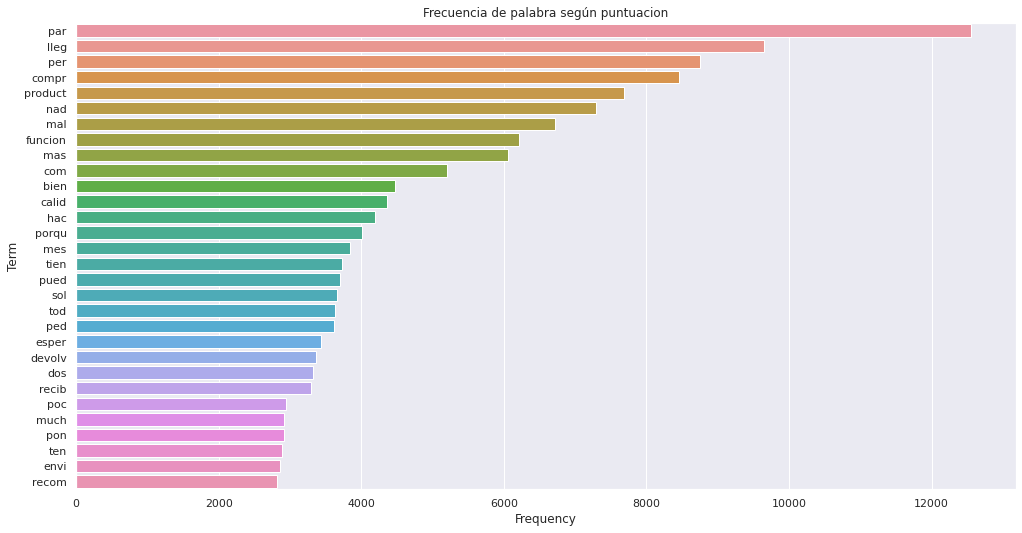

Nro de reseñas calificadas con 1 estrella =  11507

      Term  Frequency
0      par      12554
1     lleg       9655
2      per       8749
3    compr       8460
4  product       7684
5      nad       7293
6      mal       6718
7  funcion       6213
8      mas       6051
9      com       5198


In [52]:
#1 estrella
datos_reseña_1 = ds_train[(ds_train.stars == 1)]  #Tomo las reseñas calificadas con una estrella.
datos_1 = datos_reseña_1[['review_body','stars']]   #Me quedo con el cuerpo de las columnas reseña y el puntaje.
#print(datos.shape) 
print('')
print(datos_1.head())
print('')
print('----------------------------------------------------------')

## Comienzo a procesar las reseñas y la frecuencia:
todos_reseñas_1 = []
for i in range(datos_1.shape[0]):
    review_1 = datos_1['review_body'].iloc[i] #seleccionar cada reseña
    review_1 = review_1.lower() # paso a minusculas a minusculas.
    review_1 = re.sub(r'\d+','', review_1) #saco numeros
    review_1 =  tokenizer.tokenize(review_1)  #Tokenizo
    review_1 = [palabra for palabra in review_1 if len(palabra)>2] #Elimino las palabras de menos de 3 letras.
    review_1 = [stemm_español.stem(w) for w in review_1]   #Stemming de reseñas.
      # Filtrar por stopwords
    reseña_sin_sw_1 = []
    for palabra in review_1:
        if palabra not in stops:
            reseña_sin_sw_1.append(palabra)
    todos_reseñas_1.append(reseña_sin_sw_1) #agregar el resultado a la lista


todos_reseñas_1 = list(itertools.chain(*todos_reseñas_1)) #convierte una lista de listas en una unica lista
freq_resenas_1 = nltk.FreqDist(todos_reseñas_1) # Reviso la frecuencia de las palabras de los titulos. las claves en FreqDist son palabras, y el valor es el número total de apariciones de la palabra.
freq_resenas_1 = dict(freq_resenas_1) #crea el diccionario
  # Convierto a df:
df_1 = pd.DataFrame(freq_resenas_1.items()) # Hay que ponerle el metodo items()= los valores devueltos por ese método son tuplas de la clave y el valor.
df_1.columns = ['Term','Frequency']
df_resenas_1 = df_1
df_resenas_1.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar por frecuencia de mayor a menor
df_resenas_1.reset_index(drop = True, inplace=True) #resetea el indice
  # Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_resenas_1['Term'].iloc[:30], x = df_resenas_1['Frequency'].iloc[:30])
print('Puntuacion: 1')
plt.title('Frecuencia de palabra según puntuacion')
#for item in plot.get_xticklabels():
 #   item.set_rotation(90)
plt.show()
print('Nro de reseñas calificadas con 1 estrella = ', df_resenas_1.shape[0]) # '
print('')
print(df_resenas_1.head(10)) #




                                             review_body  stars
40000  Los tornillos no ajustan bien, se caen. No lo ...      2
40001  Si haces varias impresiones seguidas aparecen ...      2
40002      es pequeño no coincide con la pantalla del a1      2
40003  No lleva nada para trasportarla y es un poco r...      2
40004  a ver si me explico , su software reconoce las...      2

----------------------------------------------------------
Puntuacion: 2


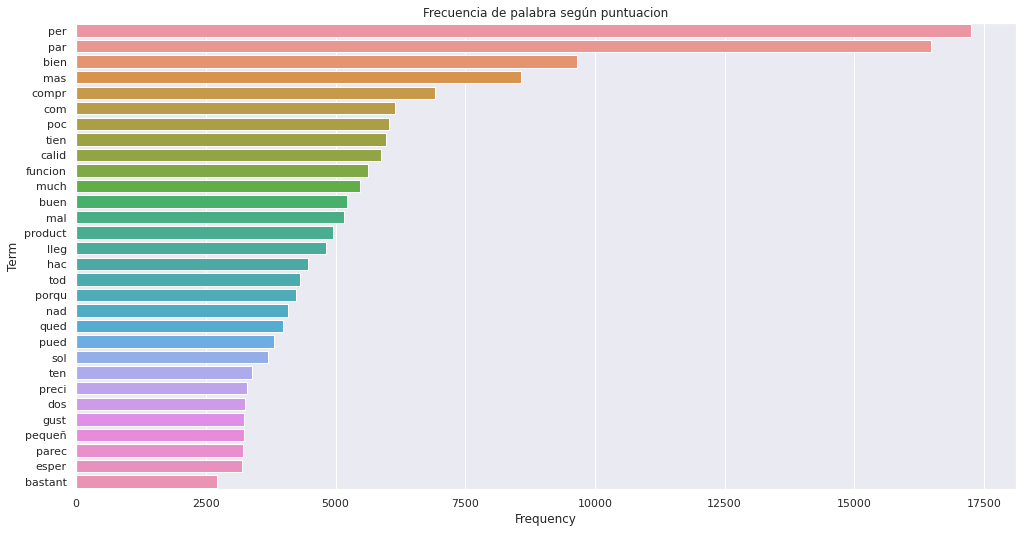

Nro de reseñas calificadas con 2 estrellas =  12491

      Term  Frequency
0      per      17252
1      par      16476
2     bien       9662
3      mas       8575
4    compr       6918
5      com       6148
6      poc       6027
7     tien       5977
8    calid       5881
9  funcion       5634


In [53]:
#2 estrellas
datos_reseña_2 = ds_train[(ds_train.stars == 2)]  #Tomo las reseñas.
datos_2 = datos_reseña_2[['review_body','stars']]        #Me quedo con el cuerpo de la review y el puntaje.
#print(datos.shape) 
print('')
print(datos_2.head())
print('')
print('----------------------------------------------------------')

## Comienzo a procesar las reviews y calculo la frecuencia:
todos_reseñas_2 = []
for i in range(datos_2.shape[0]):
    review_2 = datos_2['review_body'].iloc[i] #seleccionar cada reseña
    review_2 = review_2.lower() # paso a minusculas a minusculas.
    review_2 = re.sub(r'\d+','', review_2) #saco numeros
    review_2 =  tokenizer.tokenize(review_2)  #Tokenizo
    review_2 = [palabra for palabra in review_2 if len(palabra)>2] #Elimino las palabras de menos de 3 letras.
    review_2 = [stemm_español.stem(w) for w in review_2]   #Stemming de reseñas.
      # Filtrar por stopwords
    reseña_sin_sw_2 = []
    for palabra in review_2:
        if palabra not in stops:
            reseña_sin_sw_2.append(palabra)
    todos_reseñas_2.append(reseña_sin_sw_2) #agregar el resultado a la lista
     
todos_reseñas_2 = list(itertools.chain(*todos_reseñas_2)) #convierte una lista de listas en una unica lista
freq_resenas_2 = nltk.FreqDist(todos_reseñas_2) # Reviso la frecuencia de las palabras de los titulos sin sarcasmo.
freq_resenas_2 = dict(freq_resenas_2)
  # Convierto a df:
df_2 = pd.DataFrame(freq_resenas_2.items()) # Hay que ponerle el metodo items()
df_2.columns = ['Term','Frequency']
df_resenas_2 = df_2
df_resenas_2.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar por frecuencia
df_resenas_2.reset_index(drop = True, inplace=True)
  # Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_resenas_2['Term'].iloc[:30], x = df_resenas_2['Frequency'].iloc[:30])
print('Puntuacion: 2')
plt.title('Frecuencia de palabra según puntuacion')
#for item in plot.get_xticklabels():
 #   item.set_rotation(90)
plt.show()
print('Nro de reseñas calificadas con 2 estrellas = ', df_resenas_2.shape[0]) # '
print('')
print(df_resenas_2.head(10)) #


                                             review_body  stars
80000  cabe bien un móvil de 5,5 y cumple su función ...      3
80001  El aparato tiene un tamaño perfecto. Y la embo...      3
80002  La luces llegaron en tiempo y bien, las ocho f...      3
80003  No sé puede apagar, está todo el rato consumie...      3
80004  Vino sin la goma ajustable en la tapa y si pon...      3

----------------------------------------------------------
Puntuacion: 3


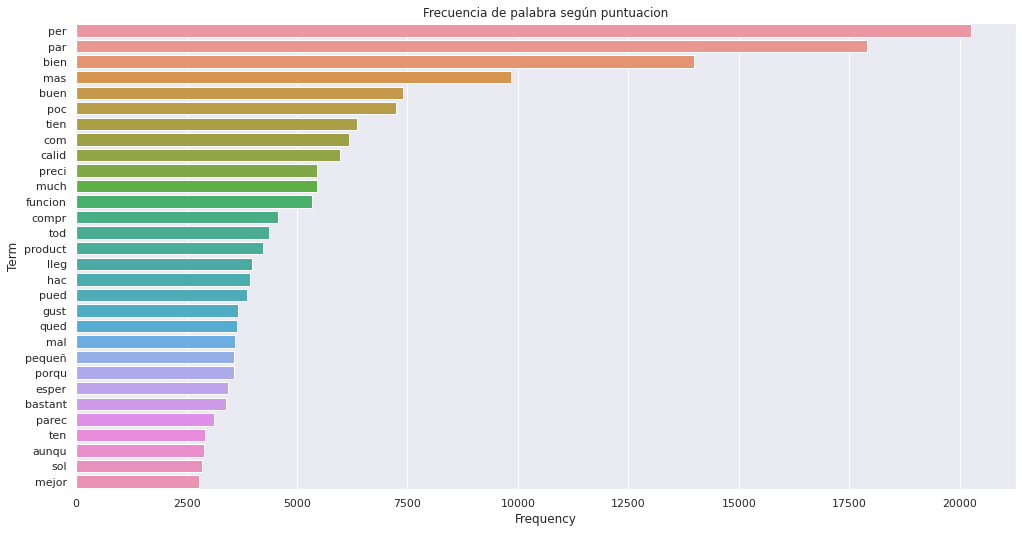

Nro de reseñas calificadas con 3 estrellas =  12269

    Term  Frequency
0    per      20258
1    par      17894
2   bien      13991
3    mas       9845
4   buen       7402
5    poc       7242
6   tien       6363
7    com       6165
8  calid       5970
9  preci       5443


In [54]:
#3 estrellas
datos_reseña_3 = ds_train[(ds_train.stars == 3)]  #Tomo las reseñas.
datos_3 = datos_reseña_3[['review_body','stars']]        #Me quedo con el cuerpo de la review y el puntaje.
#print(datos.shape) 
print('')
print(datos_3.head())
print('')
print('----------------------------------------------------------')

## Comienzo a procesar las reviews y calculo la frecuencia:
todos_reseñas_3 = []
for i in range(datos_3.shape[0]):
    review_3 = datos_3['review_body'].iloc[i] #seleccionar cada reseña
    review_3 = review_3.lower() # paso a minusculas a minusculas.
    review_3 = re.sub(r'\d+','', review_3) #saco numeros
    review_3 =  tokenizer.tokenize(review_3)  #Tokenizo
    review_3 = [palabra for palabra in review_3 if len(palabra)>2] #Elimino las palabras de menos de 3 letras.
    review_3 = [stemm_español.stem(w) for w in review_3]   #Stemming de reseñas.
     
      # Filtrar por stopwords
    reseña_sin_sw_3 = []
    for palabra in review_3:
        if palabra not in stops:
            reseña_sin_sw_3.append(palabra)
    todos_reseñas_3.append(reseña_sin_sw_3) #agregar el resultado a la lista
      #Chequeo que se haya heho bien el proceso anterior:
      #todos_reviews_malos[34] # Lo hace bien. Pude sacarle los numeros y signos de puntuación y espacios.

todos_reseñas_3 = list(itertools.chain(*todos_reseñas_3)) #convierte una lista de listas en una unica lista
freq_resenas_3 = nltk.FreqDist(todos_reseñas_3) # Reviso la frecuencia de las palabras de los titulos sin sarcasmo.
freq_resenas_3 = dict(freq_resenas_3)
  # Convierto a df:
df_3 = pd.DataFrame(freq_resenas_3.items()) # Hay que ponerle el metodo items()
df_3.columns = ['Term','Frequency']
df_resenas_3 = df_3
df_resenas_3.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar por frecuencia
df_resenas_3.reset_index(drop = True, inplace=True)
  # Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_resenas_3['Term'].iloc[:30], x = df_resenas_3['Frequency'].iloc[:30])
print('Puntuacion: 3')
plt.title('Frecuencia de palabra según puntuacion')
#for item in plot.get_xticklabels():
 #   item.set_rotation(90)
plt.show()
print('Nro de reseñas calificadas con 3 estrellas = ', df_resenas_3.shape[0]) # '
print('')
print(df_resenas_3.head(10)) #


                                              review_body  stars
120000            Tiene buena pinta, veremos el resultado      4
120001     Entrega rápida como siempre pero falta factura      4
120002                           Está bien y envío rápido      4
120003  Queda muy bien, material duradero y tamaño per...      4
120004              Genial aunque huele mucho a pegamento      4

----------------------------------------------------------
Puntuacion: 4


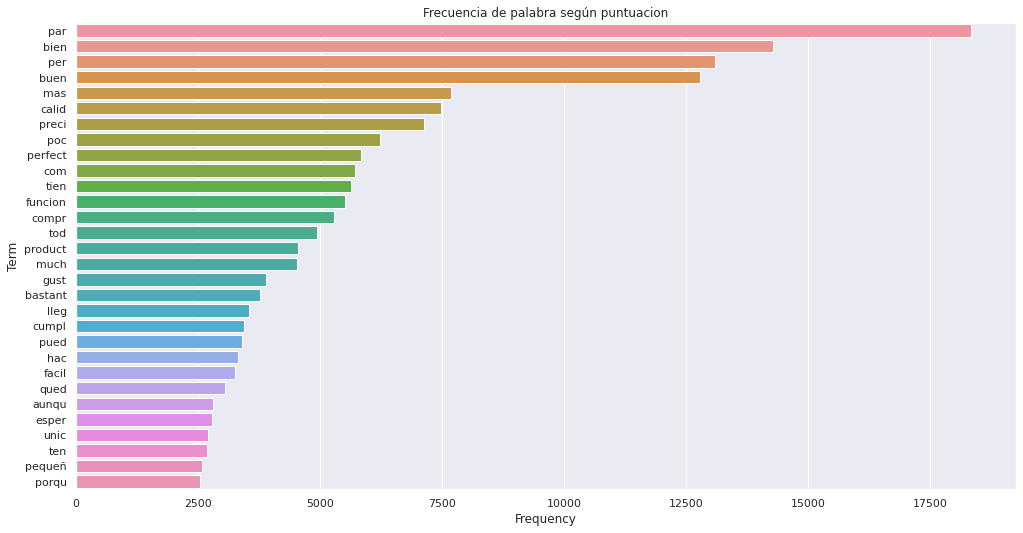

Nro de reseñas calificadas con 4 estrellas =  11971

      Term  Frequency
0      par      18334
1     bien      14272
2      per      13092
3     buen      12777
4      mas       7674
5    calid       7482
6    preci       7136
7      poc       6220
8  perfect       5833
9      com       5708


In [55]:
#4 estrellas
datos_reseña_4 = ds_train[(ds_train.stars == 4)]  #Tomo las peores/mejores reviews.
datos_4 = datos_reseña_4[['review_body','stars']]        #Me quedo con el cuerpo de la review y el puntaje.
#print(datos.shape) 
print('')
print(datos_4.head())
print('')
print('----------------------------------------------------------')

## Comienzo a procesar las reviews y calculo la frecuencia:
todos_reseñas_4 = []
for i in range(datos_4.shape[0]):
    review_4 = datos_4['review_body'].iloc[i] #seleccionar cada reseña
    review_4 = review_4.lower() # paso a minusculas a minusculas.
    review_4 = re.sub(r'\d+','', review_4) #saco numeros
    review_4 =  tokenizer.tokenize(review_4)  #Tokenizo
    review_4 = [palabra for palabra in review_4 if len(palabra)>2] #Elimino las palabras de menos de 3 letras.
    review_4 = [stemm_español.stem(w) for w in review_4]   #Stemming de reseñas.
      # Filtrar por stopwords
    reseña_sin_sw_4 = []
    for palabra in review_4:
        if palabra not in stops:
            reseña_sin_sw_4.append(palabra)
    todos_reseñas_4.append(reseña_sin_sw_4) #agregar el resultado a la lista
    
todos_reseñas_4 = list(itertools.chain(*todos_reseñas_4)) #convierte una lista de listas en una unica lista
freq_resenas_4 = nltk.FreqDist(todos_reseñas_4) # Reviso la frecuencia de las palabras de los titulos sin sarcasmo.
freq_resenas_4 = dict(freq_resenas_4)
  # Convierto a df:
df_4 = pd.DataFrame(freq_resenas_4.items()) # Hay que ponerle el metodo items()
df_4.columns = ['Term','Frequency']
df_resenas_4 = df_4
df_resenas_4.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar por frecuencia
df_resenas_4.reset_index(drop = True, inplace=True)
  # Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_resenas_4['Term'].iloc[:30], x = df_resenas_4['Frequency'].iloc[:30])
print('Puntuacion: 4')
plt.title('Frecuencia de palabra según puntuacion')
#for item in plot.get_xticklabels():
 #   item.set_rotation(90)
plt.show()
print('Nro de reseñas calificadas con 4 estrellas = ', df_resenas_4.shape[0]) # '
print('')
print(df_resenas_4.head(10)) #


                                              review_body  stars
160000  Es muy práctico para cuando me voy de vacacion...      5
160001  Cumple su función calidad precio bien. Buen ma...      5
160002                       Perfecto.. Es lo que buscaba      5
160003  MUY BUENA RELACIÓN CALIDAD-PRECIO, ES SILENCIO...      5
160004  a mi hija le encanta, aunque hubiera preferido...      5

----------------------------------------------------------
Puntuacion: 5


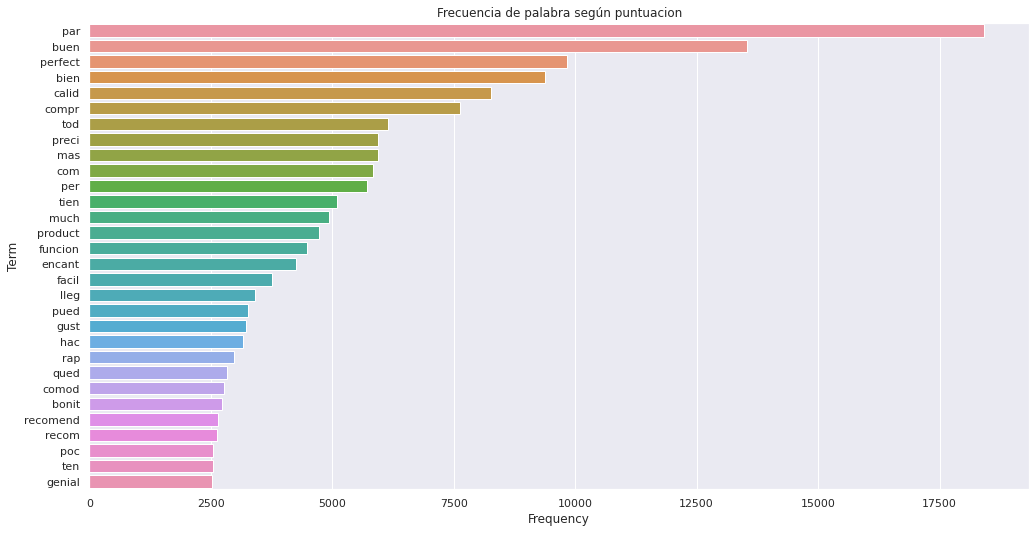

Nro de reseñas calificadas con 5 estrellas =  12038

      Term  Frequency
0      par      18422
1     buen      13543
2  perfect       9828
3     bien       9375
4    calid       8271
5    compr       7625
6      tod       6153
7    preci       5946
8      mas       5939
9      com       5844


In [56]:
#5 estrellas
datos_reseña_5 = ds_train[(ds_train.stars == 5)]  #Tomo las peores/mejores reviews.
datos_5 = datos_reseña_5[['review_body','stars']]        #Me quedo con el cuerpo de la review y el puntaje.
#print(datos.shape) 
print('')
print(datos_5.head())
print('')
print('----------------------------------------------------------')

## Comienzo a procesar las reviews y calculo la frecuencia para las malas:
todos_reseñas_5 = []
for i in range(datos_5.shape[0]):
    review_5 = datos_5['review_body'].iloc[i] #seleccionar cada reseña
    review_5 = review_5.lower() # paso a minusculas a minusculas.
    review_5 = re.sub(r'\d+','', review_5) #saco numeros
    review_5 =  tokenizer.tokenize(review_5)  #Tokenizo
    review_5 = [palabra for palabra in review_5 if len(palabra)>2] #Elimino las palabras de menos de 3 letras.
    review_5 = [stemm_español.stem(w) for w in review_5]   #Stemming de reseñas.
      # Filtrar por stopwords
    reseña_sin_sw_5 = []
    for palabra in review_5:
        if palabra not in stops:
            reseña_sin_sw_5.append(palabra)
    todos_reseñas_5.append(reseña_sin_sw_5) #agregar el resultado a la lista
     
todos_reseñas_5 = list(itertools.chain(*todos_reseñas_5)) #convierte una lista de listas en una unica lista
freq_resenas_5 = nltk.FreqDist(todos_reseñas_5) # Reviso la frecuencia de las palabras de los titulos sin sarcasmo.
freq_resenas_5 = dict(freq_resenas_5)
  # Convierto a df:
df_5 = pd.DataFrame(freq_resenas_5.items()) # Hay que ponerle el metodo items()
df_5.columns = ['Term','Frequency']
df_resenas_5 = df_5
df_resenas_5.sort_values(by = ['Frequency'],ascending= False, inplace= True ) # ordenar por frecuencia
df_resenas_5.reset_index(drop = True, inplace=True)
  # Grafico:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_resenas_5['Term'].iloc[:30], x = df_resenas_5['Frequency'].iloc[:30])
print('Puntuacion: 5')
plt.title('Frecuencia de palabra según puntuacion')
#for item in plot.get_xticklabels():
 #   item.set_rotation(90)
plt.show()
print('Nro de reseñas calificadas con 5 estrellas = ', df_resenas_5.shape[0]) # '
print('')
print(df_resenas_5.head(10)) #

In [57]:
cruza_stem = pd.concat([df_resenas_1, df_resenas_2, df_resenas_3, df_resenas_4, df_resenas_5], axis=1)
cruza_stem.head(10)

Term  Frequency     Term  Frequency   Term  Frequency     Term  \
0      par    12554.0      per      17252    per    20258.0      par   
1     lleg     9655.0      par      16476    par    17894.0     bien   
2      per     8749.0     bien       9662   bien    13991.0      per   
3    compr     8460.0      mas       8575    mas     9845.0     buen   
4  product     7684.0    compr       6918   buen     7402.0      mas   
5      nad     7293.0      com       6148    poc     7242.0    calid   
6      mal     6718.0      poc       6027   tien     6363.0    preci   
7  funcion     6213.0     tien       5977    com     6165.0      poc   
8      mas     6051.0    calid       5881  calid     5970.0  perfect   
9      com     5198.0  funcion       5634  preci     5443.0      com   

   Frequency     Term  Frequency  
0    18334.0      par    18422.0  
1    14272.0     buen    13543.0  
2    13092.0  perfect     9828.0  
3    12777.0     bien     9375.0  
4     7674.0    calid     8271.0  
5     7482.0    compr     7625.0  
6     7136.0      tod     6153.0  
7     6220.0    preci     5946.0  
8     5833.0      mas     5939.0  
9     5708.0      com     5844.0


**-----------------------------------------------------------------------------------------------------------------------**

**Luego del stematizado, tenemos que:** 

Se determinan las frecuencias de las 5 palabras mas repetidas para:

Reseñas - 
Estrellas= 1:

1º) par = 12554

2º) lleg = 9655

3º) per = 8749

4º) compr = 8460

5º) product = 7684

--------------------

Reseñas - 
Estrellas = 2:


1º) per = 17252

2º) par = 16476

3º) bien = 9662

4º) mas = 8575

5º) compr = 6918

--------------------

Reseñas -
Estrellas = 3:


1º) per = 20258

2º) par = 17894

3º) bien = 13991

4º) mas = 9845

5º) buen = 7402

--------------------

Reseñas - 
Estrellas = 4:


1º) par = 18334

2º) bien = 14272

3º) per = 13092

4º) buen = 12777

5º) mas = 7674

--------------------

Reseñas - 
Estrellas = 5:

1º) par = 18422

2º) buen = 13543

3º) perfect = 9828

4º) bien = 9375

5º) calid = 8271


La palabra 'par' está en todas las puntuaciones, Si bien aparece con menor frecuencia en la puntuacion de 1 strella, lo que marcaría alguna diferencia,  daría la pauta de que es una palabra prescindible a la hora de ponderar/calificar.
La palabra 'bien' no aparece entre las 10 más frecuentes de las reseñas calificadas con una estrella, aunque sí en el resto (entre las primeras 5).
al reves, la palara 'per'aparece en todas menos en las calificadas con 5 estrellas, entre las primeras 3.

A la luz de la comparacion entre esta instancia y la mera normalizacion, vamos encontrando mayores diferencias entre las reseñas mejores y peores puntuadas.
Aun así, no podemos tomar esta intancia como suficiente.

A partir de la stemmatizacion, continuamos con el modelado de datos

- lemmatización.
(###ver!!!)
- Me voy a quedar con los 5 tipos de productos mas resenados para hacer el modelo.


In [58]:
#-------------------------------------------------------------------------------
## Repito el proceso anterior para desvincularlo del proceso de la Lemmatizing
#-------------------------------------------------------------------------------

#ds_train_m = ds_train[(ds_train['product_category'] == 'home')] #<-- si elijo quedarme con la o las categorias más frecuentes
#datos_m = ds_train_m[['review_body','stars']]
datos_m = ds_train[['review_body','stars']]   #Me quedo con el cuerpo de la review y el puntaje.

## Voy a tener que tomar una porción menor del data set porque los modelos y
## procesos de lemmatizing no funcionan bien:

#muestra = 0.2 # Elijo el 20% del Data Set: De otra forma la corrida tarda mucho y mequedo sin RAM.
#datos_m = datos_m.sample(muestra = percent, replace = True, axis = 'index') # Selecciono un 20% random de la data para hacer proceso de Lemma y Stemm, y generar el modelo con el mejor método.
print(datos_m.shape) 
datos_m.head()

(200000, 2)


review_body  stars
0  Nada bueno se me fue ka pantalla en menos de 8...      1
1  Horrible, nos tuvimos que comprar otro porque ...      1
2  Te obligan a comprar dos unidades y te llega s...      1
3  No entro en descalificar al vendedor, solo pue...      1
4               Llega tarde y co la talla equivocada      1

In [59]:
#tomo las 5 categorías de productos más reseñafos para alivianar el df
mask_m=ds_train[((ds_train.product_category == "home")) & ((ds_train.product_category == "wireless") | (ds_train.product_category == "toy") | (ds_train.product_category == "sports"))|(ds_train.product_category == "pc")]  
datos_filtrados=pd.DataFrame(mask_m)
datos_filtrados.head()
datos_filtrados.size #su tamaño
datos_filtrados.shape



(11191, 8)

In [60]:
datos_filtrados = datos_filtrados[['review_body','stars']]
datos_filtrados.shape

(11191, 2)

In [61]:
#decido tomar un porcentaje del ds debido a que al ser de gran tamaño me demora el procesamiento.
#o puedo tomar una parte del DS tomando sólo los más buscados

#datos_filtrados.sample(frac=0.35).shape #tomo el 35% del total

In [62]:
'''
## Distribución de la puntuación: Chequeo que sea una distribución uniforme: (si me quedo con home solamente, sino ya fue presentado antes)
scale = 7
plt.figure()
sns.set(rc={'figure.figsize':(12+scale,8.27+scale)})
plt.title('Distribución de puntuaciones')
sns.countplot(x = "stars", data = datos_m, order = datos_m["stars"].value_counts().index)
'''

'\n## Distribución de la puntuación: Chequeo que sea una distribución uniforme: (si me quedo con home solamente, sino ya fue presentado antes)\nscale = 7\nplt.figure()\nsns.set(rc={\'figure.figsize\':(12+scale,8.27+scale)})\nplt.title(\'Distribución de puntuaciones\')\nsns.countplot(x = "stars", data = datos_m, order = datos_m["stars"].value_counts().index)\n'

In [63]:
NLP = spacy.load("es_core_news_sm", disable=['ner', 'parser']) #traigo la librería de spacy porque puede lemmatizar en idioma español,
# Seteo el pipeline a español: Deshabilito el ner y parser para aumentar eficiencia en la corrida
tokenizer = RegexpTokenizer(r'\w+') #creo obj tokenizador.


In [64]:
# Proceso las reseñas:
#tomar una parte del ds, porque todo es muy pesado. 
#ver cómo tomarlo de forma balanceada (porcentajes que se correlacionen con las categorias)
resenas_lemmatizadas= []

for i in range(datos_filtrados.shape[0]): 
    review = datos_filtrados['review_body'].iloc[i] #selecciono cada reseña
    review = review.lower() #paso a minusculas (norm).
    review = re.sub(r'\d+','', review) #quito numeros 
    review =  tokenizer.tokenize(review) #Tokenizo
    #Stop Words.
    resenas_sin_sw = []
    for palabra in review:
        if palabra not in stops:
           resenas_sin_sw.append(palabra)
    review = [palabra for palabra in resenas_sin_sw if (palabra not in ("bien","calidad","producto","precio","bastante","llegado","aunque") and len(palabra)>3)] 
    #Elimino las palabras de menos de 3 letras (en gral de significado irrelevante) y las que más se repiten entre nro de estrellas.
    #Lemmatizamos reseñas.
    r_lemma = [NLP(w) for w in review] # Aplicamos el Lemmatizer (Esto puede tardar un rato): No hace falta decirle que tipo de palabra es.
    r_lemma = ' '.join([token.text_with_ws for token in r_lemma])
    resenas_lemmatizadas.append(r_lemma) #agregar el resultado a la lista
    #"producto","bien","buena","precio","producto","calidad","bastante","llegado","aunque"
    

In [65]:
#resenas_lemmatizadas
## Agrego la culumna al ds original:
datos_filtrados["review_lemma"] = resenas_lemmatizadas
ds_train_lemma = datos_filtrados[['review_lemma','stars']]
ds_train_lemma.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
print(ds_train_lemma.shape) 
ds_train_lemma.head()

(11191, 2)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


review_lemma  stars
15   estafa compreis copias archivos desaparecen di...      1
105  cargaba llegó tirar encendía cargaba vale pena...      1
115  exteriormente chulo conectarlo bloquea ordenad...      1
119  llego cristal roto puse contacto vendedor cont...      1
133  primera impresión utilizar alfombrilla buena p...      1

In [66]:

# hago un refresh (no lemma) para volver a modelar con stemm

# creo objetos para stemming y token:
spanish_stemmer = SnowballStemmer('spanish')
tokenizer = RegexpTokenizer(r'\w+') 

# Proceso las resenas:

todos_resenas_stemm= []

for i in range(datos_filtrados.shape[0]):
    review = datos_filtrados['review_body'].iloc[i] #seleccionar cada resña
    review = review.lower()#paso a minusculas.
    review = re.sub(r'\d+','', review) #quito los numeros.
    review =  tokenizer.tokenize(review) #Token
    # Filtrar por stopwords
    resenas_sin_sw = []
    for palabra in review:
        if palabra not in stops:
           resenas_sin_sw.append(palabra)
    review = [palabra for palabra in resenas_sin_sw if (palabra not in ("bien","calidad","producto","precio","bastante","llegado","aunque") and len(palabra)>3)] #Elimino las palabras de menos de 2 letras y la que más se repiten entre reviews.
    #Stemizado de los reviews.
    review = [spanish_stemmer.stem(w) for w in review]         
    review = " ".join(review)
    todos_resenas_stemm.append(review) #agregar el resultado a la lista

In [67]:
## Agrego la columna de reseñas stemm al ds:
datos_filtrados["review_stemm"] = todos_resenas_stemm
ds_train_stemm = datos_filtrados[['review_stemm','stars']]
ds_train_stemm.dropna(axis=0,inplace=True)  # elimino valores nulos si los hay
print(ds_train_stemm.shape) 
ds_train_stemm.head()

(11191, 2)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


review_stemm  stars
15   estaf compreis copi archiv desaparec dic forma...      1
105            carg lleg tir encend carg val pen compr      1
115                  exterior chul conect bloque orden      1
119      lleg cristal rot pus contact vendedor contest      1
133  primer impresion utiliz alfombrill buen pas me...      1

In [68]:
#nube de palabras!!!
from wordcloud import WordCloud

def ver_wordcloud(palabras): #creamos funcion wordcloud
    text = ' '.join(palabras)
    wordcloud = WordCloud(background_color='white',width=900,height=450).generate(text.strip())
    plt.figure(figsize = (15,8), facecolor = None)
    plt.imshow(wordcloud, interpolation='kaiser')
    plt.axis("off")
    plt.show()

------------------
Cantidad de estrellas asignadas
1
------------------


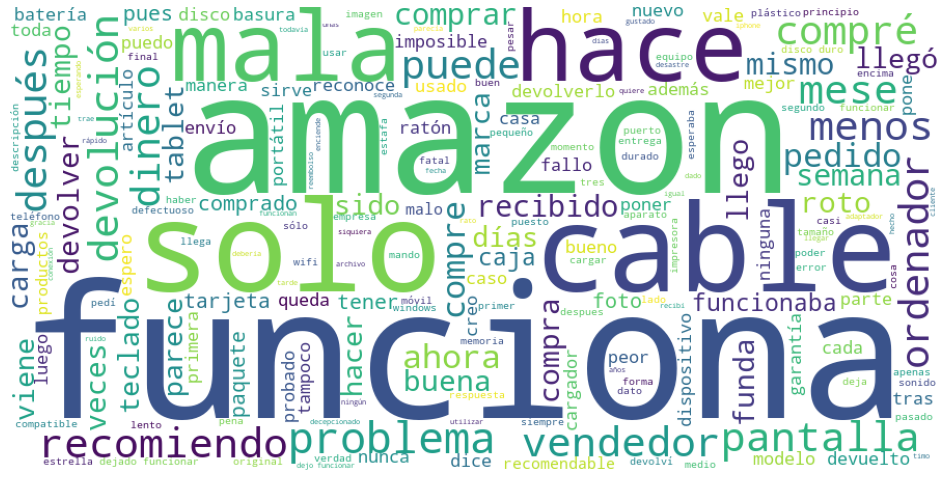

------------------
Cantidad de estrellas asignadas
2
------------------


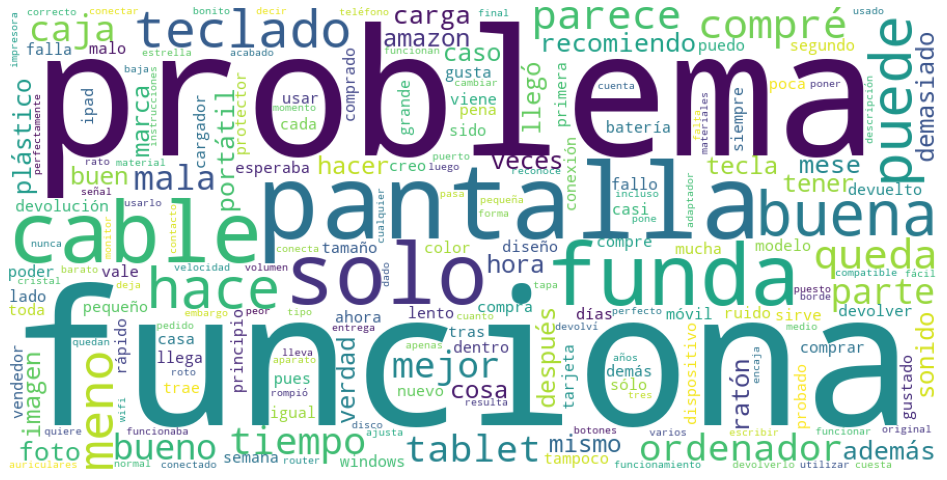

------------------
Cantidad de estrellas asignadas
3
------------------


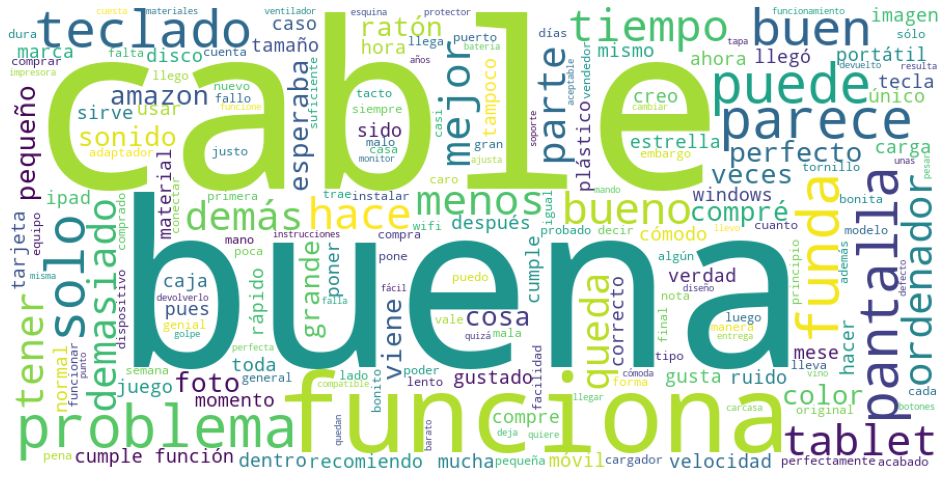

------------------
Cantidad de estrellas asignadas
4
------------------


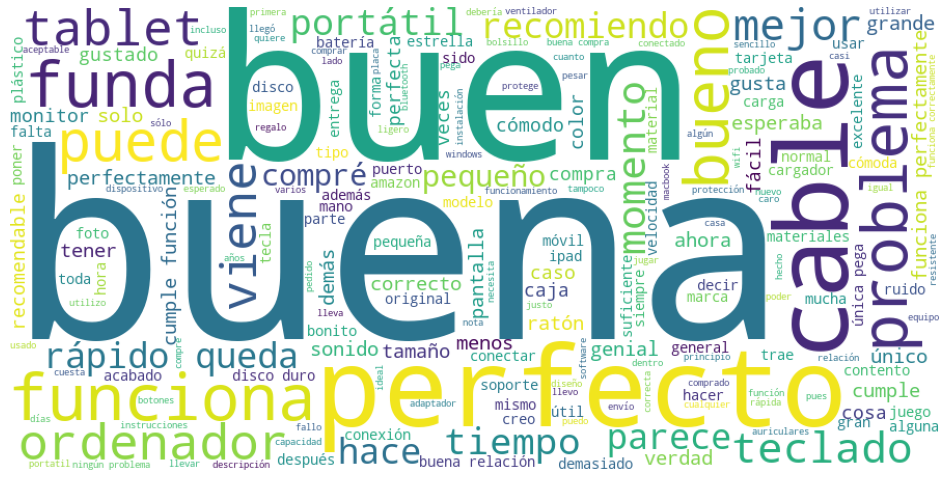

------------------
Cantidad de estrellas asignadas
5
------------------


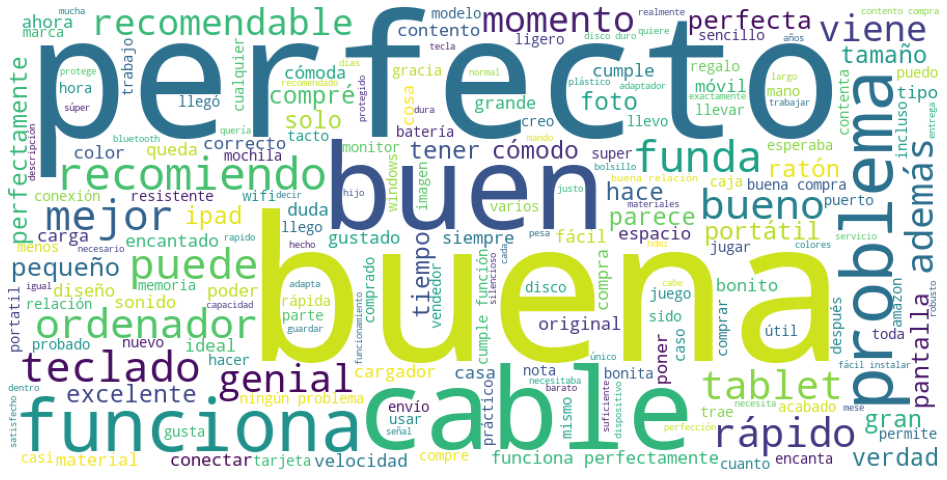

In [69]:
#Cuáles son las palabras que más aparecen en cada puntuacion de estrellas - gráfico
stars = [1, 2, 3, 4, 5]
for star in stars:
  data_words_ = ds_train_lemma[(ds_train_lemma['stars'] == star)]
  print('------------------')
  print('Cantidad de estrellas asignadas')
  print(star)
  print('------------------')
  ver_wordcloud(data_words_['review_lemma'])

------------------
Cantidad de estrellas asignadas
1
------------------


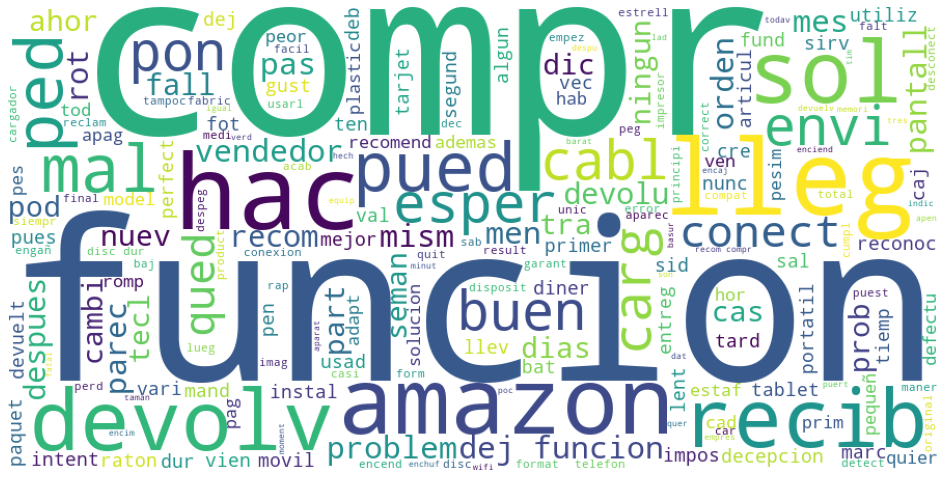

------------------
Cantidad de estrellas asignadas
2
------------------


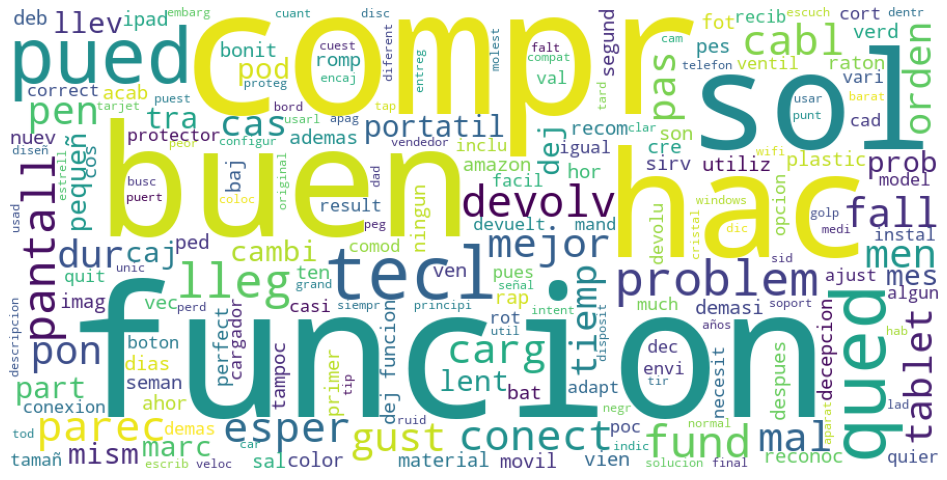

------------------
Cantidad de estrellas asignadas
3
------------------


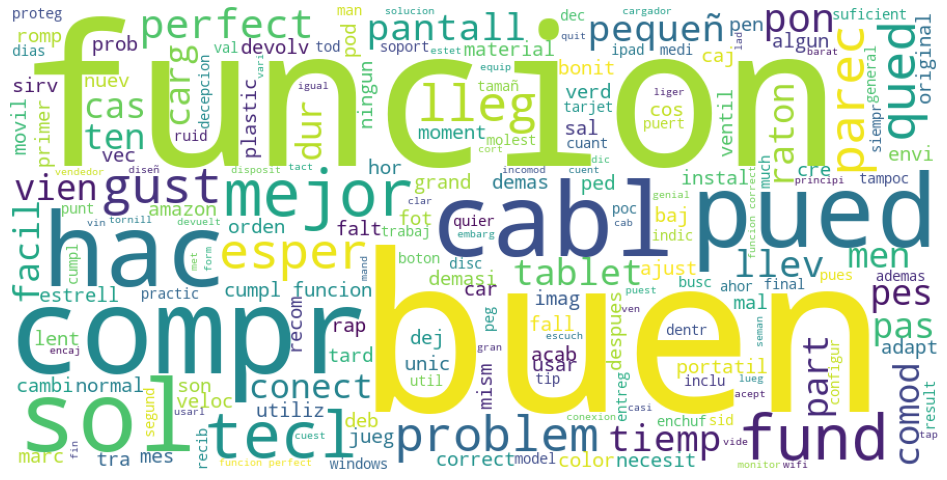

------------------
Cantidad de estrellas asignadas
4
------------------


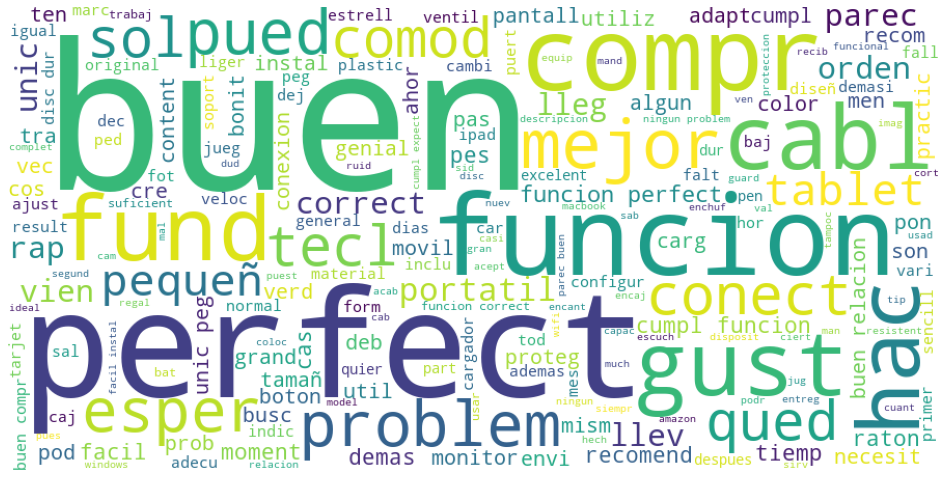

------------------
Cantidad de estrellas asignadas
5
------------------


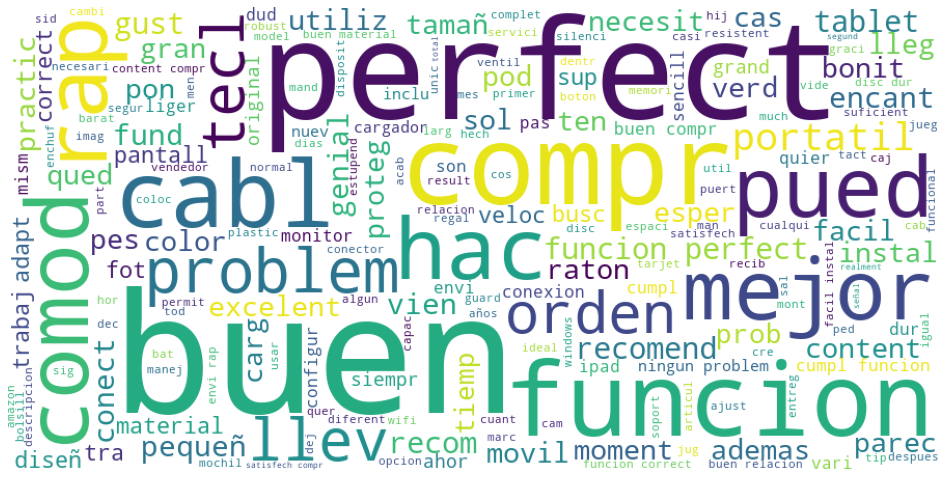

In [70]:
#no tiene mucho sentido hacerla en el ds stemmatizado, pero aun así...
stars = [1, 2, 3, 4, 5]
for star in stars:
  data_words_ = ds_train_stemm[(ds_train_stemm['stars'] == star)]
  print('------------------')
  print('Cantidad de estrellas asignadas')
  print(star)
  print('------------------')
  ver_wordcloud(data_words_['review_stemm'])

--------------------------------------------------------------------------------------------------------------

Existen palabras que se repiten en todas o casi todas las reseñas de todas las puntuaciones, sean buenas o malas.

Una manera de tratar esto es aplicar el metodo TF-IDF, ponderando las palabras que no se repiten entre categorías de estrellas


In [71]:

# matriz:
max_features = 1500 # Usaremos solo las 1500 palabras más frecuentes para armar los vectores (bajar costo)

tf_idf  = TfidfVectorizer(max_features=max_features,sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1,3)) #creo objeto tf_idf...

In [72]:
estrellas = ds_train_stemm['stars']
resenas_tf_idf = tf_idf.fit_transform(ds_train_stemm['review_stemm']).toarray() #...y lo aplico a resenas

In [73]:
#Tomamos las palabras
palabras_tf_idf  = tf_idf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [74]:
# Vizualizamos las 50 palabras/stemm mas usadas
print("50 palabras mas frecuentes - tf_idf: ",palabras_tf_idf[0:50])

50 palabras mas frecuentes - tf_idf:  ['abaj', 'abiert', 'abre', 'abri', 'abrir', 'abrirl', 'absolut', 'acab', 'acab buen', 'acced', 'acces', 'accesori', 'acept', 'acert', 'aciert', 'acolch', 'aconsej', 'acopl', 'acord', 'acostumbr', 'activ', 'actual', 'actualiz', 'adapt', 'adapt perfect', 'adecu', 'adel', 'adem', 'ademas', 'adhes', 'adicional', 'adjunt', 'admit', 'adquir', 'agarr', 'agrad', 'agradec', 'agu', 'aguant', 'agujer', 'ahor', 'ahor funcion', 'ahorr', 'air', 'ajust', 'ajust perfect', 'alcanc', 'alcanz', 'alfombrill', 'algui']


In [75]:
#funcion para matriz de confusión: 

def confusion(ytest,y_pred):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred,normalize='true')
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",ax=ax) #fmt=".0f",
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

In [76]:
print(resenas_tf_idf[1,:].sum())
print(resenas_tf_idf.shape)
print(ds_train_stemm['review_stemm'].shape)

2.7324744251368367
(11191, 1500)
(11191,)


In [77]:
## y hacemos el train test split (previo establecer target)) :
x = resenas_tf_idf # Matriz de resenas stemmatizadas con las palabras de mayor frecuencia.
y = estrellas # Lista de estrellas - Puntajes.
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

**Modelo Benchmark**

---
Modelo = elegimos un modelo simple Naive Bayes (parametros por defecto).

Metricas =  confusion matrix, accuracy y F1-SCORE


In [78]:
nb = GaussianNB() 
nb.fit(xtrain,ytrain)

GaussianNB()

----------------------------------------------------------------
Resultados de modelo con data Stemmatizada y TF-IDF
----------------------------------------------------------------
Gauss


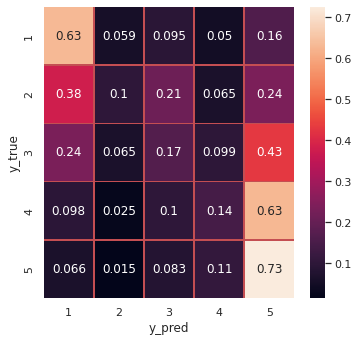

acc :  0.3653960690887433
F1 Score:  0.3127812067617658
              precision    recall  f1-score   support

           1       0.45      0.63      0.53       666
           2       0.38      0.10      0.16       645
           3       0.23      0.17      0.20       596
           4       0.32      0.14      0.20       714
           5       0.36      0.73      0.48       737

    accuracy                           0.37      3358
   macro avg       0.35      0.36      0.31      3358
weighted avg       0.35      0.37      0.32      3358



In [79]:
# grafico de la matriz de confusión y el accuracy:
print('----------------------------------------------------------------')
#print('Resultados de modelos con data Lemmatizada y X armado con TF-IDF')
print('Resultados de modelo con data Stemmatizada y TF-IDF')
print('----------------------------------------------------------------')

print('Gauss')
y_pred_nb = nb.predict(xtest)
confusion(ytest,y_pred_nb)

print("acc : ",accuracy_score(ytest, y_pred_nb))
print("F1 Score: ", f1_score(ytest ,y_pred_nb, average='macro'))
#print("R2 Score: ", r2_score(ytest ,y_pred_nb))
print(classification_report(ytest, y_pred_nb))


**Modelos**

Sólo aplicaremos los modelos al ds stemmatizado.

**Modelo** = **Linear Support Vector Classifier - SVC** 

In [80]:
#svc_lineal = LinearSVC(C = 3,multi_class = 'ovr', class_weight='balanced') ## Usar un kernel no lineal. (Suport vector machines no lineales)
#svc_lineal.fit(xtrain,ytrain)

In [81]:
# grafico de la matriz de confusión y el accuracy:
#print('----------------------------------------------------------------')
#print('Resultados de modelos con data Lemmatizada y X armado con TF-IDF')
#print('Resultados de modelo con data Stemmatizada y TF-IDF')
#print('----------------------------------------------------------------')

#print('Linear Support Vector Classifier')
#y_pred_svc_lineal = svc_lineal.predict(xtest)
#confusion(ytest,y_pred_svc_lineal)

#print("acc : ",accuracy_score(ytest, y_pred_svc_lineal))
#print("F1 Score: ", f1_score(ytest ,y_pred_svc_lineal, average='macro'))
#print(classification_report(ytest, y_pred_svc_lineal))

**Modelo** = **Support Vector Classifier - SVC**

In [82]:
svc = SVC()
svc.fit(xtrain,ytrain)

SVC()

In [83]:
'''
# grafico de la matriz de confusión y el accuracy:
print('----------------------------------------------------------------')
#print('Resultados de modelos con data Lemmatizada y X armado con TF-IDF')
print('Resultados de modelo con data Stemmatizada y TF-IDF')
print('----------------------------------------------------------------')

print('Support Vector Classifier')
y_pred_svc = svc.predict(xtest)
confusion(ytest,y_pred_svc)

print("acc : ",accuracy_score(ytest, y_pred_svc))
print("F1 Score: ", f1_score(ytest ,y_pred_svc, average='macro'))
print(classification_report(ytest, y_pred_svc))
'''

'\n# grafico de la matriz de confusión y el accuracy:\nprint(\'----------------------------------------------------------------\')\n#print(\'Resultados de modelos con data Lemmatizada y X armado con TF-IDF\')\nprint(\'Resultados de modelo con data Stemmatizada y TF-IDF\')\nprint(\'----------------------------------------------------------------\')\n\nprint(\'Support Vector Classifier\')\ny_pred_svc = svc.predict(xtest)\nconfusion(ytest,y_pred_svc)\n\nprint("acc : ",accuracy_score(ytest, y_pred_svc))\nprint("F1 Score: ", f1_score(ytest ,y_pred_svc, average=\'macro\'))\nprint(classification_report(ytest, y_pred_svc))\n'

**Modelo** = **Random Forest Classifier**

In [84]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100,bootstrap = True, verbose=2,
                               max_features = 'sqrt')
RF.fit(xtrain,ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.9s finished


RandomForestClassifier(max_features='sqrt', verbose=2)

In [85]:
'''
# grafico de la matriz de confusión y el accuracy:
print('----------------------------------------------------------------')
#print('Resultados de modelos con data Lemmatizada y X armado con TF-IDF')
print('Resultados de modelo con data Stemmatizada y TF-IDF')
print('----------------------------------------------------------------')

print('Random Forest Classifier')
y_pred_RF = RF.predict(xtest)
confusion(ytest,y_pred_RF)

print("acc : ",accuracy_score(ytest, y_pred_RF))
print("F1 Score: ", f1_score(ytest ,y_pred_RF, average='macro'))
print(classification_report(ytest, y_pred_RF))
'''

'\n# grafico de la matriz de confusión y el accuracy:\nprint(\'----------------------------------------------------------------\')\n#print(\'Resultados de modelos con data Lemmatizada y X armado con TF-IDF\')\nprint(\'Resultados de modelo con data Stemmatizada y TF-IDF\')\nprint(\'----------------------------------------------------------------\')\n\nprint(\'Random Forest Classifier\')\ny_pred_RF = RF.predict(xtest)\nconfusion(ytest,y_pred_RF)\n\nprint("acc : ",accuracy_score(ytest, y_pred_RF))\nprint("F1 Score: ", f1_score(ytest ,y_pred_RF, average=\'macro\'))\nprint(classification_report(ytest, y_pred_RF))\n'

**Modelo** = **XGBoost Classifier**

In [86]:
import xgboost as xgb
XGB =  xgb.XGBClassifier()
XGB.fit(xtrain,ytrain)

XGBClassifier(objective='multi:softprob')

In [87]:
'''
# grafico de la matriz de confusión y el accuracy:
print('----------------------------------------------------------------')
#print('Resultados de modelos con data Lemmatizada y X armado con TF-IDF')
print('Resultados de modelo con data Stemmatizada y TF-IDF')
print('----------------------------------------------------------------')

print('XGBoost Classifier')
y_pred_XGB = XGB.predict(xtest)
confusion(ytest,y_pred_XGB)

print(classification_report(ytest, y_pred_XGB))
'''

"\n# grafico de la matriz de confusión y el accuracy:\nprint('----------------------------------------------------------------')\n#print('Resultados de modelos con data Lemmatizada y X armado con TF-IDF')\nprint('Resultados de modelo con data Stemmatizada y TF-IDF')\nprint('----------------------------------------------------------------')\n\nprint('XGBoost Classifier')\ny_pred_XGB = XGB.predict(xtest)\nconfusion(ytest,y_pred_XGB)\n\nprint(classification_report(ytest, y_pred_XGB))\n"

-------------------------------------------------------------------

Modelo: Support Vector Classifier - SVC

-------------------------------------------------------------------


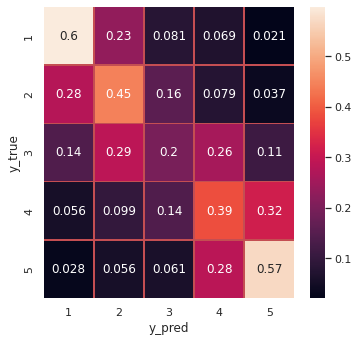

Accuracy:  0.44639666468135797
F1:  0.43369040507284734
              precision    recall  f1-score   support

           1       0.55      0.60      0.57       666
           2       0.40      0.45      0.42       645
           3       0.28      0.20      0.23       596
           4       0.37      0.39      0.38       714
           5       0.56      0.57      0.56       737

    accuracy                           0.45      3358
   macro avg       0.43      0.44      0.43      3358
weighted avg       0.44      0.45      0.44      3358



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


-------------------------------------------------------------------

Modelo: Random Forest Classifier

-------------------------------------------------------------------


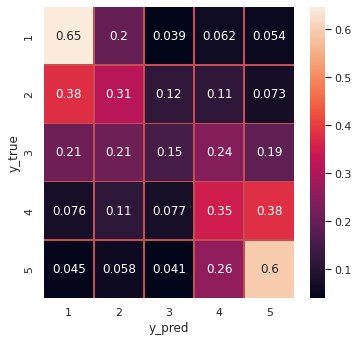

Accuracy:  0.42167957117331745
F1:  0.3966796701198902
              precision    recall  f1-score   support

           1       0.49      0.65      0.56       666
           2       0.35      0.31      0.33       645
           3       0.33      0.15      0.21       596
           4       0.36      0.35      0.35       714
           5       0.48      0.60      0.53       737

    accuracy                           0.42      3358
   macro avg       0.40      0.41      0.40      3358
weighted avg       0.40      0.42      0.40      3358

-------------------------------------------------------------------

Modelo: XGBoost Classifier

-------------------------------------------------------------------


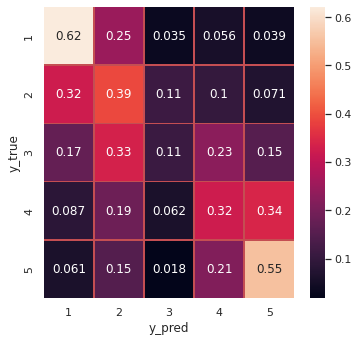

Accuracy:  0.40857653365098273
F1:  0.3839287923644019
              precision    recall  f1-score   support

           1       0.50      0.62      0.55       666
           2       0.29      0.39      0.33       645
           3       0.30      0.11      0.16       596
           4       0.37      0.32      0.34       714
           5       0.50      0.55      0.53       737

    accuracy                           0.41      3358
   macro avg       0.39      0.40      0.38      3358
weighted avg       0.40      0.41      0.39      3358



In [88]:
modelo_df = [ 'Support Vector Classifier - SVC','Random Forest Classifier', 'XGBoost Classifier']

for i, model in enumerate([svc,RF, XGB]):
    y_train_pred_df = model.predict(xtrain)
    y_test_pred_df = model.predict(xtest)

    print('-------------------------------------------------------------------')
    print(f'\nModelo: {modelo_df[i]}\n')
    print('-------------------------------------------------------------------')
    #agregar confusion (sin print)
    acc = accuracy_score(ytest, y_test_pred_df)
    confusion(ytest,y_test_pred_df)
    F1_Score =  f1_score(ytest ,y_test_pred_df, average='macro')


    print('Accuracy: ', acc)
    print('F1: ', F1_Score)
    print(classification_report(ytest, y_test_pred_df))


**Optimizacion de modelo SVC**


In [89]:
optimoSVC = SVC()

parametros = {"gamma": ['scale','auto'],  # [0.001, 0.01 , 0.1]
              "C": [0.1 , 1 , 2 , 5 , 10],
              "degree": [1 , 2 , 3 , 4],
              "coef0": [0.1 , 0.01 , 1 , 2 , 3 , 10],
              "class_weight": [None, 'balanced'],
              "break_ties" : [False, True],
              "random_state": [42, None],
              "probability": [True,False]}
              

In [ ]:
SVC_RS = RandomizedSearchCV(estimator=optimoSVC, scoring =  'r2',#'accuracy', 
                           param_distributions = parametros,
                           cv = 2, n_iter = 5, n_jobs=-1,verbose=1)

SVC_RS.fit(xtrain, ytrain) 

Fitting 2 folds for each of 5 candidates, totalling 10 fits


In [ ]:
'''
print(" Random Search " )
print(" Mejor estimador:", SVC_RS.best_estimator_)
print(" Mejor score:", SVC_RS.best_score_)
print(" Los mejores Hiperparámetros:", SVC_RS.best_params_)
'''

**Optimizacion de Random Forest Classifier**

In [ ]:
optimoRF = RandomForestClassifier()
parametros = {"n_estimators": [100, 200, 300, 400],
              "max_depth": [3, 5, 7, 9, 11, 15, 20, 30],
              "max_features": ["log2", "sqrt"], 
              "oob_score": [True, False], 
              "random_state":[42]}

In [ ]:
RF_RS = RandomizedSearchCV(estimator=optimoRF, scoring = 'accuracy',
                           param_distributions = parametros,
                           cv = 2, n_iter = 5, n_jobs=-1,verbose=1)

RF_RS.fit(xtrain, ytrain) 

In [ ]:
'''
print(" Random Search Random Forest" )
print(" El mejor estimador:", RF_RS.best_estimator_)
print(" El mejor score:", RF_RS.best_score_)
print(" Los mejores hiperparámetros:", RF_RS.best_params_)
'''

In [ ]:

modelo_df = [ 'Support Vector Classifier - SVC optimizado','Random Forest Classifier optimizado']

for i, model in enumerate([SVC_RS,RF_RS]):
    y_train_pred_df = model.predict(xtrain)
    y_test_pred_df = model.predict(xtest)
    
    print('-------------------------------------------------------------------')
    print(f'\nModelo: {modelo_df[i]}\n')
    print('-------------------------------------------------------------------')
    best_param = model.best_params_
    best_score = model.best_score_
    best_estimator = model.best_estimator_

    acc = accuracy_score(ytest, y_test_pred_df)
    F1_Score =  f1_score(ytest ,y_test_pred_df, average='macro')
    print('')
    print('Mariz de confusion')
    print('')
    confusion(ytest,y_test_pred_df)

    print('Accuracy: ', acc)
    #print('Matriz de confusion: ', confusion)
    print('F1: ', F1_Score)
    print(classification_report(ytest, y_test_pred_df))
    print('Mejor Hiperparámetro: ', best_param)
    print('Mejor Score: ',best_score )
    print('Mejor estimador: ', best_estimator)

Hasta aquí: 

utilizamos un modelo simple Naive Bayes con parametros por defecto, como benchmark.

Comparamos con un modelo SVC, un RFC y un XGBoost. Con parametros tambien por default. Optimizamos el RFC y el SVC con RandomSearch.

El modelo Benchmar tuvo buena performance en las predicción de puntuaciones extremas (5 = .73 y 1 = .63 de acc), y muy mala en puntuaciones intermedias. ACC promedio bajo = .36

De los tres modelos utilizados, el que mejor performance arrojó fue el RFC, seguido del SVC. Sin embargo se mantiene en todos la tendencia a predecir mejor en las puntuaciones extremas (5 y 1), y bajar sensiblemente las metricas en los puntajes intermedios.

En la optimización de dichos modelos obtuvimos resultados mejores, aunque no sensiblemente superiores. Aquí cabe preguntarse si el modelo no sería mejor si 
convertimos el problema en uno binario donde se asignarían únicamente las etiquetas Positiva y Negativa a cada crítica y generar un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. El desempeño sería mejor , definitivamente, puesto que deberíamos hacer un modelado más exahustivo en cuanto a la frecuencia de palabras positivas y negativas (o las etiquetas que fueran). Correspondería pensar una estrategia para la puntuacion 3: se anula? se selecciona?

Los modelos optimizados fueron RFC y SVC. LAs métricas mejoraron, pero persiste la tendencia.
El mejor modelo resultó ser el RFC con un acc promedio de 42.1 y buenas performance en puntaje 1 y 5.

**ds_test**

In [ ]:
datos_t = ds_test[['review_body','stars']]   #Me quedo con el cuerpo de la review y el puntaje.

print(datos_t.shape) 
datos_t.head()

In [ ]:
#tomo las 5 categorías de productos más reseñados, tal como hice con el anterior
mask_t=ds_test[((ds_test.product_category == "home")) & ((ds_test.product_category == "wireless") | (ds_test.product_category == "toy") | (ds_test.product_category == "sports"))|(ds_test.product_category == "pc")]  
datos_filtrados=pd.DataFrame(mask_t)
datos_filtrados.head(3)


In [ ]:
datos_filtrados = datos_filtrados[['review_body','stars']]
datos_filtrados.head()

In [ ]:
NLP = spacy.load("es_core_news_sm", disable=['ner', 'parser']) #traigo la librería de spacy porque puede lemmatizar en idioma español,
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
todas_las_resenas_stemm= []

for i in range(datos_filtrados.shape[0]): 
    review = datos_filtrados['review_body'].iloc[i] #selecciono cada reseña
    review = review.lower() #paso a minusculas (norm).
    review = re.sub(r'\d+','', review) #quito numeros 
    review =  tokenizer.tokenize(review) #Tokenizo
    #Stop Words.
    resenas_sin_sw = []
    for palabra in review:
        if palabra not in stops:
           resenas_sin_sw.append(palabra)
    review = [palabra for palabra in resenas_sin_sw if (palabra not in ("bien","calidad","producto","precio","bastante","llegado","aunque") and len(palabra)>3)] 
    #Elimino las palabras de menos de 3 letras (en gral de significado irrelevante) y las que más se repiten entre nro de estrellas.
    #Stemizado de los reviews.
    review = [spanish_stemmer.stem(w) for w in review]         
    review = " ".join(review)
    todas_las_resenas_stemm.append(review) #agregar el resultado a la lista

    
    

In [ ]:
## Agrego la culumna de reviwes stemmizados al data set original:
datos_filtrados["review_stemm"] = todas_las_resenas_stemm
data_model_test_stemm_CV = datos_filtrados[['review_stemm','stars']]
data_model_test_stemm_CV.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
print(data_model_test_stemm_CV.shape) 
data_model_test_stemm_CV.head()

In [ ]:
## Paso resenas stemm y puntajes a listas:

list_resenas = list(data_model_test_stemm_CV['review_stemm'].values) # Para variable X
list_estrellas = data_model_test_stemm_CV['stars'].values # variable target Y

In [ ]:
#matriz:
# Voy a probar dos tecnicas de vectorización:
##-------------------------------------------
max_features = 1500 # Usaremos solo las 1000 o 2000 palabras con mas frecuencia en todo el corpus para generar los vectores
tf_dfV  = TfidfVectorizer(max_features=max_features,sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1,3)) # Uso esta técnica sobre la CountVectorizer porque introduce más información.
matriz_resenas_tf_dfV  = tf_dfV.fit_transform(list_resenas)

In [ ]:
#vectores para crossvalidar:
x = matriz_resenas_tf_dfV.toarray() # Matriz de resenas stemmizados con las palabras de mayor frecuencia.
y = list_estrellas # Lista de estrellas - Puntajes.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics


In [ ]:
# CV model:

modelo = RandomForestClassifier(max_depth=15, max_features='sqrt', n_estimators=300,
                       random_state=42).fit(x, y) 

In [ ]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(modelo, x, y, cv=kfold, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())
print("DS", scores.std()*100)
preds = modelo.predict(x)
score_pred = metrics.accuracy_score(y, preds)
print('-------------------------------------------------------------------------')
print('Accuracy en pred', score_pred)


Conclusiones del CV:
el promedio del Accuracy es de 31 % con un desvío std del 9.7 %. En el mejor de los casos obtengo 46 % de acuracy.
Sin embargo, el accuracy en pred es de 0.96 o 96% = el modelo es bueno. 



**ds_dev**

In [ ]:
#datos_d = ds_dev[['review_body','stars']]   #Me quedo con el cuerpo de la review y el puntaje.

#print(datos_d.shape) 
#datos_d.head()

In [ ]:
#tomo las 5 categorías de productos más reseñados, tal como hice con el anterior
mask_d=ds_dev[((ds_dev.product_category == "home")) & ((ds_dev.product_category == "wireless") | (ds_dev.product_category == "toy") | (ds_dev.product_category == "sports"))|(ds_dev.product_category == "pc")]  
datos_filtrados=pd.DataFrame(mask_d)
datos_filtrados.head(3)

In [ ]:
datos_filtrados = datos_filtrados[['review_body','stars']]
datos_filtrados.head(3)

In [ ]:
NLP = spacy.load("es_core_news_sm", disable=['ner', 'parser']) #traigo la librería de spacy porque puede lemmatizar en idioma español,
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
todas_las_resenas_stemm= []

for i in range(datos_filtrados.shape[0]): 
    review = datos_filtrados['review_body'].iloc[i] #selecciono cada reseña
    review = review.lower() #paso a minusculas (norm).
    review = re.sub(r'\d+','', review) #quito numeros 
    review =  tokenizer.tokenize(review) #Tokenizo
    #Stop Words.
    resenas_sin_sw = []
    for palabra in review:
        if palabra not in stops:
           resenas_sin_sw.append(palabra)
    review = [palabra for palabra in resenas_sin_sw if (palabra not in ("bien","calidad","producto","precio","bastante","llegado","aunque") and len(palabra)>3)] 
    #Elimino las palabras de menos de 3 letras (en gral de significado irrelevante) y las que más se repiten entre nro de estrellas.
    #Stemizado de los reviews.
    review = [spanish_stemmer.stem(w) for w in review]         
    review = " ".join(review)
    todas_las_resenas_stemm.append(review) #agregar el resultado a la lista

    

In [ ]:
# Agrego la culumna de reviwes stemmizados al data set original:
datos_filtrados["review_stemm"] = todas_las_resenas_stemm
data_model_test_stemm_CV = datos_filtrados[['review_stemm','stars']]
data_model_test_stemm_CV.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
print(data_model_test_stemm_CV.shape) 
data_model_test_stemm_CV.head()

In [ ]:
## Paso resenas stemm y puntajes a listas:

list_resenas = list(data_model_test_stemm_CV['review_stemm'].values) # Para variable X
list_estrellas = data_model_test_stemm_CV['stars'].values # variable target Y

In [ ]:
#matriz:

max_features = 1500 # Usaremos solo las 1000 o 2000 palabras con mas frecuencia en todo el corpus para generar los vectores
tf_dfV  = TfidfVectorizer(max_features=max_features,sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1,3)) # Uso esta técnica sobre la CountVectorizer porque introduce más información.
matriz_resenas_tf_dfV  = tf_dfV.fit_transform(list_resenas)

In [ ]:
#vectores para crossvalidation:
x = matriz_resenas_tf_dfV.toarray() # Matriz de resenas stemmizados con las palabras de mayor frecuencia.
y = list_estrellas # Lista de estrellas - Puntajes.

In [ ]:
RFC_op_dev = RandomForestClassifier(max_depth=15, max_features='sqrt', n_estimators=300,
                       random_state=42).fit(x, y) 

In [ ]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(RFC_op_dev, x, y, cv=kfold, scoring="accuracy")
print("Metricas cross_validation", scores)
print("Media de cross_validation", scores.mean())
print("DS", scores.std()*100)
#preds = RFC_op_dev.predict(x)
score_pred = metrics.accuracy_score(y, preds)
print('-------------------------------------------------------------------------')
print('Accuracy en pred', score_pred)

In [ ]:
print('Random Forest Classifier')
y_pred_rfc = modelo_dev.predict(x)
confusion(y,y_pred_rfc)

print("acc : ",accuracy_score(y, y_pred_rfc))
print("F1 Score: ", f1_score(y, y_pred_rfc, average='macro'))
print(classification_report(y, y_pred_rfc))

Según esto último, el modelo RandomForest Classifier con sus hp optimizados es es muy bueno o esta overfiteado. Las métricas son muy superiores que el modelo benchmark y los modelos optimizados. (verase la diagonal perfectamente delimitada en la matriz de confusion)
Puede deberse a que el ds tenia muy poca cantidad de datos en relacion don ds test (ds_dev) lo cual se resolvio con el cross validation. 



-------------------------------------------------------------------------------------------------------

**Conclusiones**:

**EDA**

Los tres ds son de identica forma. Sus columnas son:

"review_id": tipo de dato alfanumerico.

"product_id": tipo de dato alfanumerico.

"reviewer_id": tipo de dato alfanumerico.

"stars": Tipo numérico (int).

"review_body": Tipo Sring.

"review_title": Tipo String.

"language": Tipo String.

"product_category": Tipo String.

Del EDA realizado en cada uno se obtuvo que: 

Sólo contienen reseñas en idioma español

ds_train tiene 200000 resenas.

ds_test y ds_dev tienen, en cambio, 5000 cada uno. Los utilizaremos para probar el/los modelos (datos diferentes)

La puntuacion es a traves del otorgamiento de estrellas de 1 a 5, donde 1 es la peor y 5 es la mejor calificacion posible.

No tienen valores faltanes.

En cuanto a la distribucion de estrellas/reseñas, exite iguales cantidades de reseñas calificadas con cada puntaje, lo que balancea el ds.

Existen 30 categorías de productos: las 5 más reseñadas/consumidas son las mismas en todos los ds.

--------------------------------------------------------------------------------
**Preprocesamiento:**

En cuanto a la frecuencia, las palabras que más se repiten son similares en todos los clusters de puntuacion (tener en cuenta que sólo se hizo una normalización): 

como representativo de los tres ds, en el ds_train las palabras con más freciencia en las diferentes calificaciones son = 

 1 estrella:

'producto' 7219 veces.
'bien' 4448 veces.
'calidad' 4349 veces.

2 estrellas:

 'bien' 59627 veces
 'calidad' 5874 veces
 'producto' 4651 veces

3 estrellas:

 'bien' 13948 veces
 'calidad' 5967 veces
 'producto' 3973 veces

4 estrellas:

 'bien' 14206 veces
 'calidad' 7476 veces
 'producto' 4332 veces

5 estrellas:

 'bien' 9333 veces
 'calidad' 8263 veces
 'producto' 4459 veces

En terminos comparativos, las que más se repiten son 'bien', 'calidad' y 'producto'. 
Por una parte, no podemos perder de vista el rol de cada palabra = puede corresponder a un concepto que hace referencia a un atributo positivo, por ejemplo, 'buena calidad'o lo contrario, 'mala calidad' (la palabra 'mal' sólo se encuentra con mayor frecuencia en las reseñas de 1, 2 y 3 estrellas), 
Esto puede ser un motivo por el cual el desempeño del/los modelos fes peor al predecir categorias intermedias (puntajes no extremos).


En cuanto al modelado, se realiza tokenizacion, lemmatizacion y stematizacion. Se eliminan las palabras de menos de 3 letras (stopwords) ya que queremos evitar su rol confundidor (en terminos conceptuales)

Trabajamos sobre ds stemmatizados, ya sea en train, test y dev.

**Modelos:**

utilizamos un modelo simple Naive Bayes con parametros por defecto, como benchmark.

Comparamos con un modelo SVC, un RFC y un XGBoost. Con parametros tambien por default. Optimizamos el RFC y el SVC con RandomSearch.

El modelo Benchmar tuvo buena performance en las predicción de puntuaciones extremas (5 = .73 y 1 = .63 de acc), y muy mala en puntuaciones intermedias. ACC promedio bajo = .36

De los tres modelos utilizados, el que mejor performance arrojó fue el RFC, seguido del SVC. Sin embargo se mantiene en todos la tendencia a predecir mejor en las puntuaciones extremas (5 y 1), y bajar sensiblemente las metricas en los puntajes intermedios.

En la optimización de dichos modelos obtuvimos resultados mejores, aunque no sensiblemente superiores. Aquí cabe preguntarse si el modelo no sería mejor si 
convertimos el problema en uno binario donde se asignarían únicamente las etiquetas Positiva y Negativa a cada crítica y generar un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. El desempeño sería mejor , definitivamente, puesto que deberíamos hacer un modelado más exahustivo en cuanto a la frecuencia de palabras positivas y negativas (o las etiquetas que fueran). Correspondería pensar una estrategia para la puntuacion 3: se anula? se selecciona?

Los modelos optimizados fueron RFC y SVC. LAs métricas mejoraron, pero persiste la tendencia.
El mejor modelo resultó ser el RFC con un acc promedio de 42.1 y buenas performance en puntaje 1 y 5.

¿Que información está usando el modelo para predecir?

Se basa en una matriz X cuyas filas se componen por los vectores generados con  TF-IDF::
Cada una de las columnas son las palabras (stemmizadas) de las reseñas.
Cada fila es cada reseña de los productos de las 5 categorías seleccionadas (y su puntuacion).
Las palabras son ponderadas dependiendo de la mayor o menor frecuencia (total e inversa) en todo el corpus.

